In [1]:
pwd

'\\\\pwcapdfs02.capsida.local\\shares$\\Histology\\Ryan\\FISH\\Analysis'

chdir = "//pwcapdfs02.capsida.local/shares$/Histology/COHO-0626M/Naive/TIF/"


def rename_files_in_directory(directory_path):
    for filename in os.listdir(directory_path):
        if "Naive_3" in filename:
            new_filename = filename.replace("Naive_3", "Naive3")
            old_file_path = os.path.join(directory_path, filename)
            new_file_path = os.path.join(directory_path, new_filename)
            os.rename(old_file_path, new_file_path)
            print(f"Renamed: {filename} -> {new_filename}")

# Example usage:
# Replace '/path/to/your/directory' with the actual path
rename_files_in_directory(chdir)

In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import warnings

warnings.filterwarnings("ignore")

##### 1. Compile All Data into A Single DataFrame
###### (If starting from complete dataframe, you can skip this section 8)

In [209]:
%%time
#Recalibrate with wave 2 
parent= "//pwcapdfs02.capsida.local//shares$//Histology//Ryan//FISH//Cropped/"
dflist = []
rbfox3list = []
dapilist = []
wprelist = []
count = 0

for root, dirs, files in os.walk(parent):
    
    for file in files: 
        print(file)
        channel = 'WPRE'
        if root.find('DAPI') != -1:
            channel = 'DAPI'
            
        elif root.find('RbFox3') != -1:
            channel = 'Rbfox3'

        elif root.find('WPRE') != -1:
            channel = 'WPRE'
        
        if  (file.find('CellPose') != -1) & (file.find('DAPI') != -1):

            
            animal = file[8:12]
        
    
            if file.find('Frontal') != -1:
                region = 'Frontal Cortex'
            elif file.find('Temporal') != -1:
                region = 'Temporal Cortex'
            elif file.find('Putamen') != -1:
                region = 'Putamen'
            elif file.find('Caudate') != -1:
                region = 'Caudate'
            elif file.find('Thalamus') != -1:
                region = 'Thalamus'
                
                
            print(region)
            #Read in the HA data
            DAPIdf = pd.read_csv(root + '/' + file)
            
            if len(DAPIdf) > 0:

                #Read in HA data (1um enlarged nuclear ROI)
                DAPIdf['Animal'] = animal
                DAPIdf['Channel'] = channel
                DAPIdf['Brain Region'] = region
                DAPIdf[['Image','Label']] = DAPIdf['Label'].str.split(':',expand=True)

                dapilist.append(DAPIdf)

                #Read in HA Halo data (1um enlarged nuclear Halo around the nucleus)
                file2 = file.replace('DAPI', 'Rbfox3')
                rbfox3df = pd.read_csv(root + '/' + file2)
                rbfox3df['Animal'] = animal
                rbfox3df['Channel'] = channel
                rbfox3df[['Image','Label']] = rbfox3df['Label'].str.split(':',expand=True)
                rbfox3list.append(rbfox3df)
                    
                #Read in the nuclear data alone
                file3 = file.replace('DAPI', 'WPRE')
                WPREdf = pd.read_csv(root + '/' + file3)
                WPREdf['Animal'] = animal
                WPREdf['Channel'] = channel
                WPREdf[['Image','Label']] = WPREdf['Label'].str.split(':',expand=True)
                wprelist.append(WPREdf)
    
                #Merge the GFP and DAPI dataframes
                df3 = DAPIdf.merge(WPREdf, how = 'inner', on = ['Label']) #GFP cols end up as _x, DAPI cols end up as _y
                df4 = df3.merge(rbfox3df, how = 'inner', on = ['Label']) #donut cols end up as standard labels
                dflist.append(df4)
                
#concatenate the dataframes
dfMergeFullSet = pd.concat(dflist)
dfDAPI = pd.concat(dapilist)
dfRBFOX3 = pd.concat(rbfox3list)
dfWPRE = pd.concat(wprelist)

cropped_2001_8-11_Frontal1.tif
cropped_2001_8-11_Frontal1.tifCellPose_DAPI.csv
Frontal Cortex
cropped_2001_8-11_Frontal1.tifCellPose_Rbfox3.csv
cropped_2001_8-11_Frontal1.tifCellPose_WPRE.csv
cropped_2001_8-11_Frontal1_rois.zip
cropped_2001_8-11_Frontal2.tif
cropped_2001_8-11_Frontal2.tifCellPose_DAPI.csv
Frontal Cortex
cropped_2001_8-11_Frontal2.tifCellPose_Rbfox3.csv
cropped_2001_8-11_Frontal2.tifCellPose_WPRE.csv
cropped_2001_8-11_Frontal2_rois.zip
cropped_2001_8-11_Frontal3.tif
cropped_2001_8-11_Frontal3.tifCellPose_DAPI.csv
Frontal Cortex
cropped_2001_8-11_Frontal3.tifCellPose_Rbfox3.csv
cropped_2001_8-11_Frontal3.tifCellPose_WPRE.csv
cropped_2001_8-11_Frontal3_rois.zip
cropped_2001_8-11_Frontal4.tif
cropped_2001_8-11_Frontal4.tifCellPose_DAPI.csv
Frontal Cortex
cropped_2001_8-11_Frontal4.tifCellPose_Rbfox3.csv
cropped_2001_8-11_Frontal4.tifCellPose_WPRE.csv
cropped_2001_8-11_Frontal4_rois.zip
cropped_2001_8-11_Putamen1.tif
cropped_2001_8-11_Putamen1.tifCellPose_DAPI.csv
Putamen
c

##### 2. Rename and Reformat Columns, Add Missing Columns

In [211]:
RBFOX3cols = [' ','Label','Area','Mean','StdDev','Min','Max','X','Y','IntDen','Median','%Area','RawIntDen','MinThr','MaxThr','Well', 'Field']
RBFOX3cols2 = [i + '_RBFOX3' for i in RBFOX3cols]
renamedict = dict(zip(RBFOX3cols, RBFOX3cols2))
dfMergeFullSet = dfMergeFullSet.rename(renamedict, axis = 1)

In [212]:
WPREcols = [i.replace('_y', '_WPRE') for i in dfMergeFullSet.columns.tolist() if i.find('_y') != -1]
Oldcols = [i for i in dfMergeFullSet.columns.tolist() if i.find('_y') != -1]
renamedict = dict(zip(Oldcols, WPREcols))
dfMergeFullSet = dfMergeFullSet.rename(renamedict, axis = 1)

In [213]:
DAPIcols = [i.replace('_x', '_DAPI') for i in dfMergeFullSet.columns.tolist() if i.find('_x') != -1]
Oldcols = [i for i in dfMergeFullSet.columns.tolist() if i.find('_x') != -1]
renamedict = dict(zip(Oldcols, DAPIcols))
dfMergeFullSet = dfMergeFullSet.rename(renamedict, axis = 1)

In [214]:
dfStudyData= dfMergeFullSet.copy().reset_index().drop("index", axis =1 )
drops = [i for i in dfStudyData.columns.tolist() if i.find('Unnamed') != -1]
dfStudyData = dfStudyData.drop(drops, axis = 1)

In [215]:
dfStudyData['COHO'] = 'COHO-0598P'


##### 4. Verify that merging went appropriately (ROI IDs from CellPose seem to work consistently)

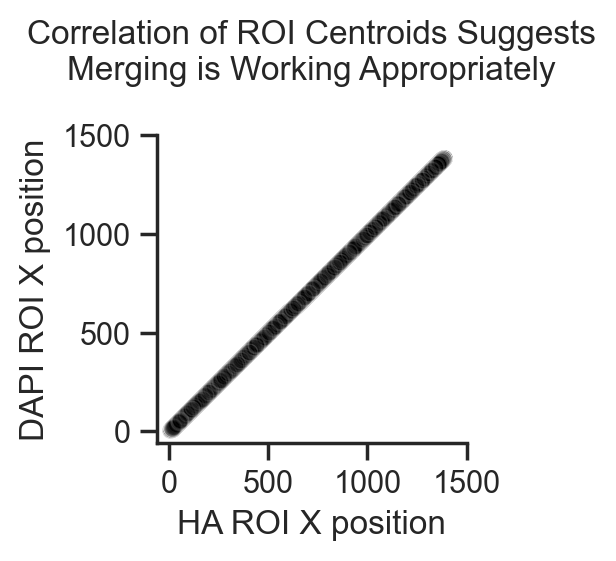

In [218]:
plt.figure(figsize = (2,2), dpi = 200)
g = sns.scatterplot(dfStudyData, x = 'X_RBFOX3', y = 'X_WPRE', alpha = 0.1, color = 'black')
sns.despine(top=True,right=True)
plt.title('Correlation of ROI Centroids Suggests\nMerging is Working Appropriately',pad=20)

g.set_xlabel('HA ROI X position')
g.set_ylabel('DAPI ROI X position')
g.set_xticks(range(0,2000,500))
g.set_yticks(range(0,2000,500))

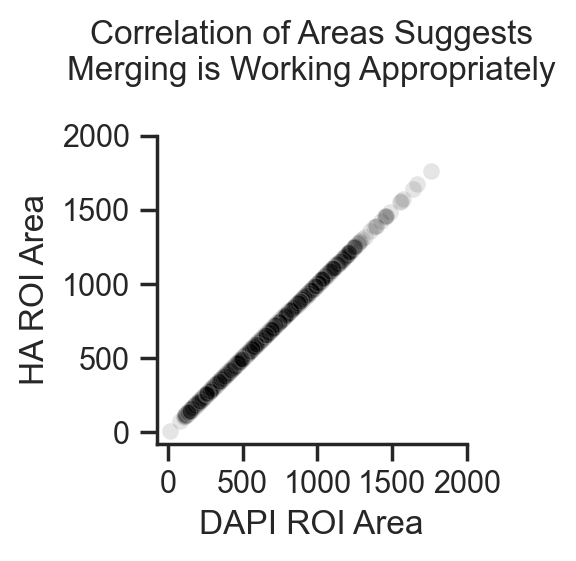

In [219]:
plt.figure(figsize = (2,2), dpi = 200)
g = sns.scatterplot(dfStudyData, y = 'Area_WPRE', x = 'Area_RBFOX3', alpha = 0.1, color = 'black')
sns.despine(top=True,right=True)
plt.title('Correlation of Areas Suggests\nMerging is Working Appropriately',pad=20)
g.set_ylabel('HA ROI Area')
g.set_xlabel('DAPI ROI Area')
g.set_xticks(range(0,2200,500))
g.set_yticks(range(0,2200,500))

##### 5. Save final dataframe

<Axes: xlabel='Mean_RBFOX3', ylabel='Mean_WPRE'>

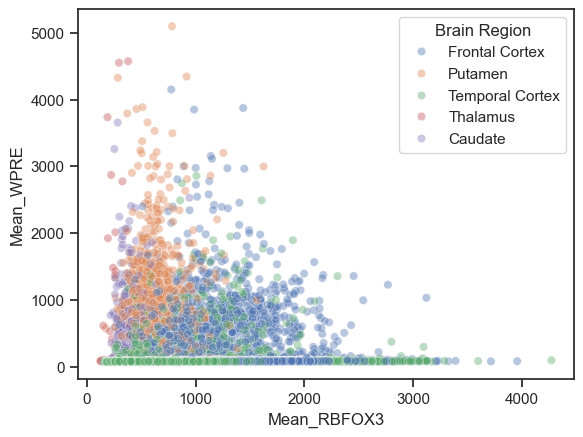

In [225]:
sns.scatterplot(dfMergeFullSet,x='Mean_RBFOX3', y= 'Mean_WPRE', hue = 'Brain Region', alpha = 0.4)

2001
2002
2501
2502
2001
2002
2501
2001
2002
2501
2502
2001
2002
2501


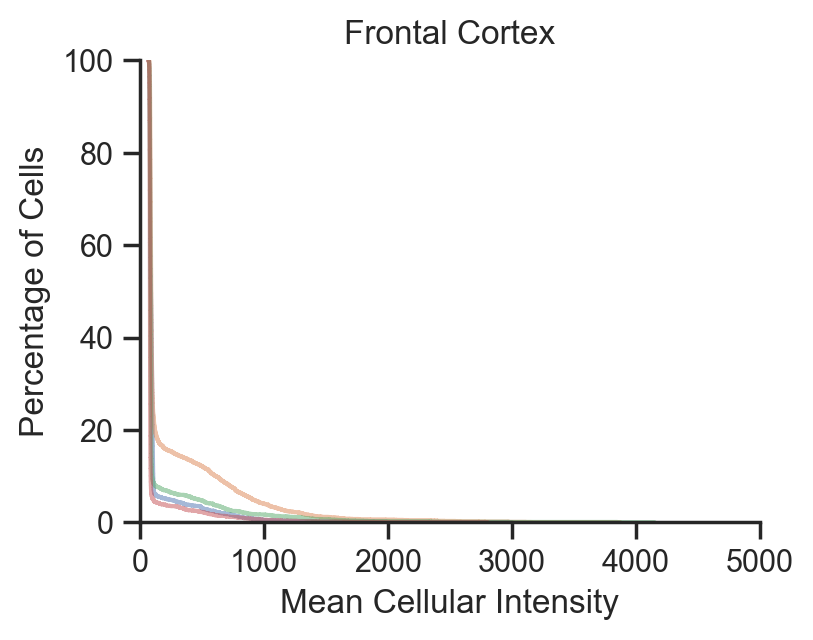

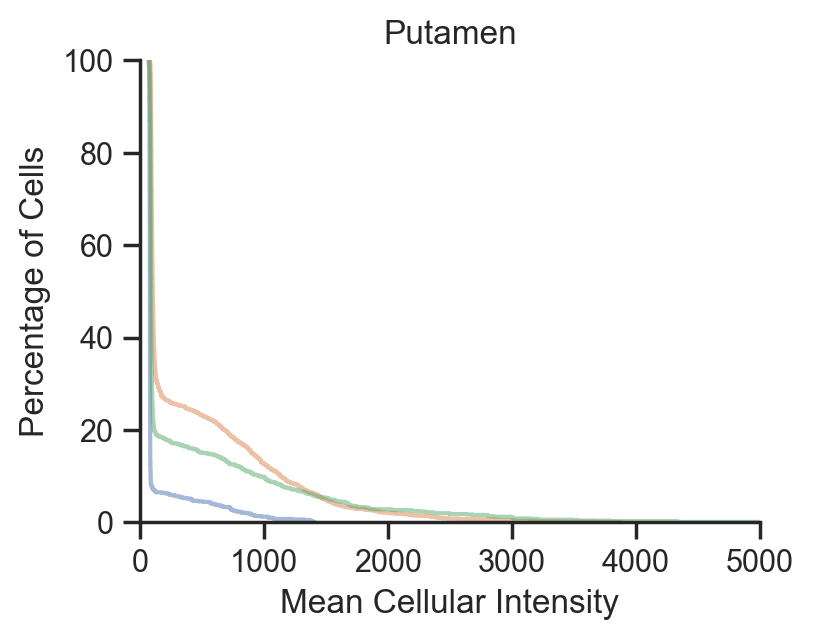

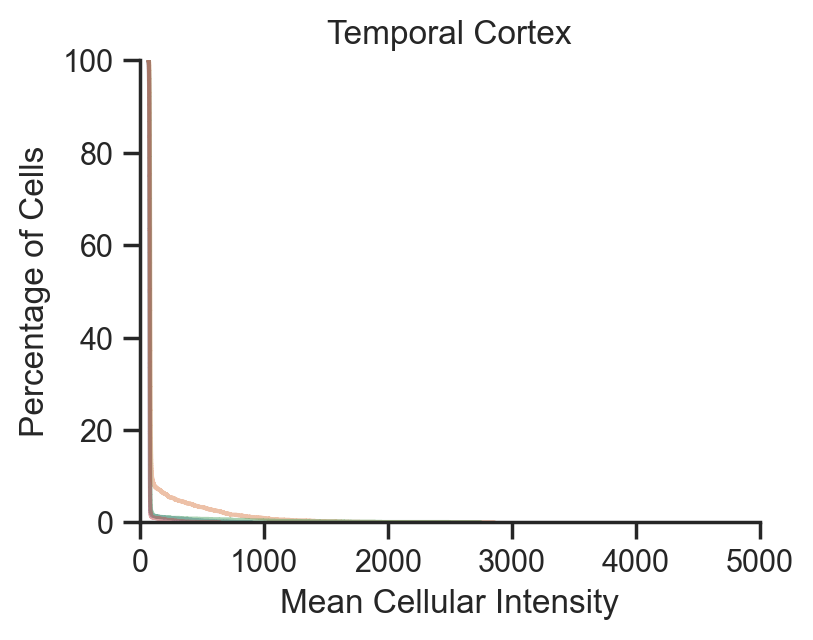

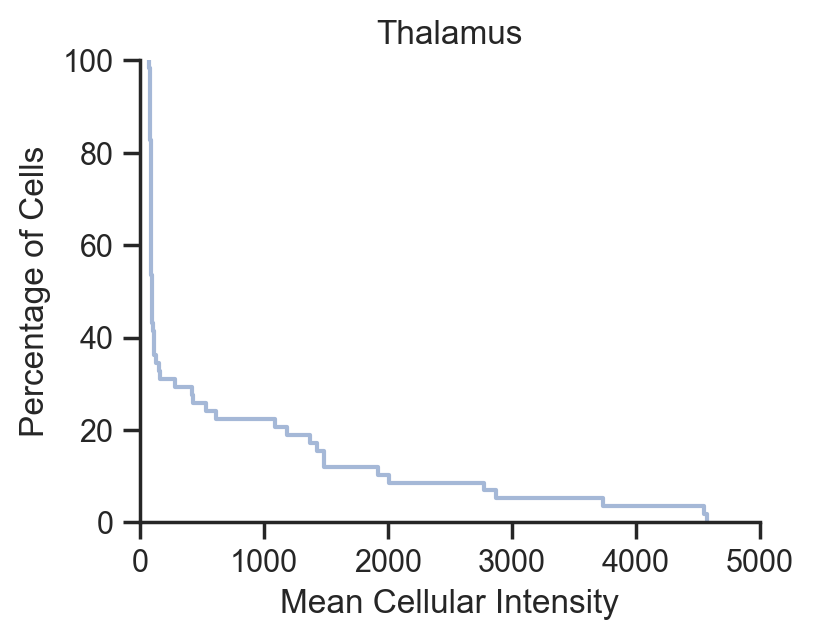

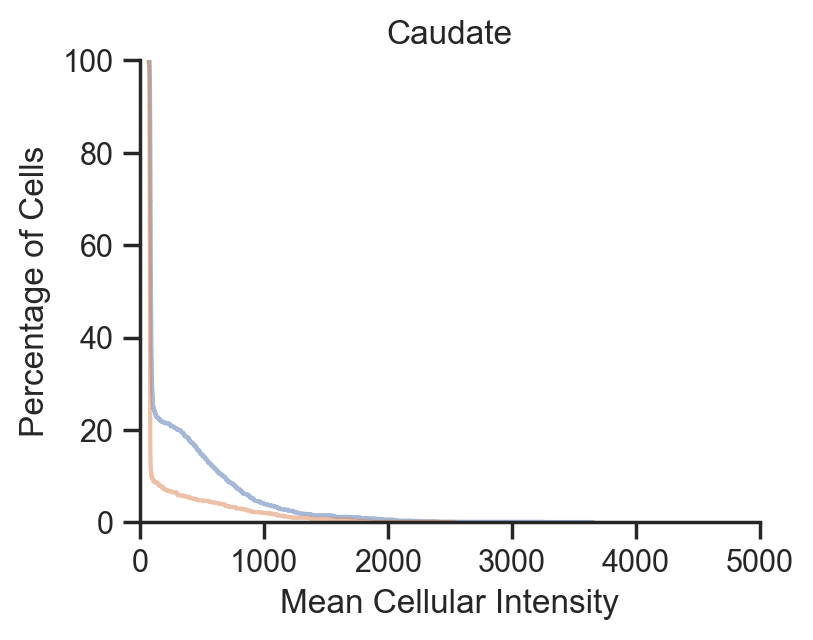

In [206]:
for region in dfStudyData['Brain Region'].unique():
    plt.figure(figsize = (4,3), dpi = 200)
    data1 = dfStudyData[dfStudyData['Brain Region'] == region]

    for animal in data1['Animal'].unique():
        print(animal)
        data2 = data1[data1['Animal'] == animal]
        #cm = cdict[data['Cargo'].unique().tolist()[0]]
        g = sns.ecdfplot(data = data2, x = 'Mean_WPRE', legend = False,alpha = 0.5, complementary = True)
        g.set_title(region)
        g.set_ylabel('Percentage of Cells')
        g.set_yticklabels(range(0,120,20))
        sns.despine(top= True, right = True)
        g.set_xlabel('Mean Cellular Intensity')
        g.set_xlim(0,5000)
    
    plt.savefig(savedir + '/Figures/' + region + '_ECDF_Mean_WPRE.png' ,bbox_inches = 'tight')

In [220]:
savedir = '//pwcapdfs02.capsida.local/shares$/Histology/Ryan/FISH/Analysis/'
os.makedirs(savedir + '/Figures/', exist_ok=True)
os.makedirs(savedir + '/FinalCSVs/', exist_ok=True)

In [221]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
sns.set_theme(style="ticks", font_scale=1)
cmap = cm.get_cmap('tab10')

In [222]:
drops = [i for i in dfStudyData.columns.tolist() if i.find('Unnamed') != -1]
dfStudyData = dfStudyData.drop(drops, axis = 1)

In [223]:
dfStudyData['Brain Region'].value_counts()

Brain Region
Temporal Cortex    13838
Frontal Cortex     10906
Putamen             3602
Caudate             2517
Thalamus              58
Name: count, dtype: int64

In [224]:
dfStudyData.to_csv(savedir + '/FinalCSVs/' + "598P_FINAL.csv")

##### 6. Read in finalized dataframe

In [226]:
WPREthresh = 125

In [228]:
totalcells = dfStudyData.groupby(['Animal', 'Brain Region', 'Image']).count()
positivecells = dfStudyData[dfStudyData['Mean_WPRE'] > WPREthresh].groupby(['Animal', 'Brain Region', 'Image']).count()

In [229]:
percentcells = positivecells/totalcells * 100
percentcells = percentcells.reset_index()

In [231]:
dfStudyData['Brain Region'].value_counts()

Brain Region
Temporal Cortex    13838
Frontal Cortex     10906
Putamen             3602
Caudate             2517
Thalamus              58
Name: count, dtype: int64

FMR1
CG3207
HK6480
MQ6868
RY9452
XB8152
CG3207
HK6480
MQ6868
RY9452
XB8152
GRN
CG3209
HK6482
MQ6770
RY9454
XB8154
CG3209
HK6482
MQ6770
RY9454
XB8154
NTC
Naive1
Naive2
Naive3
Naive1
Naive2
Naive3


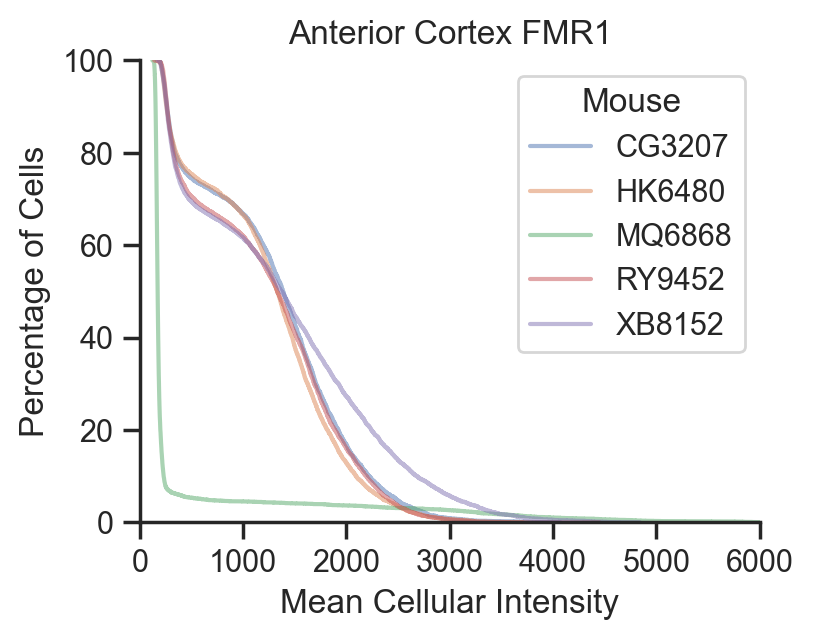

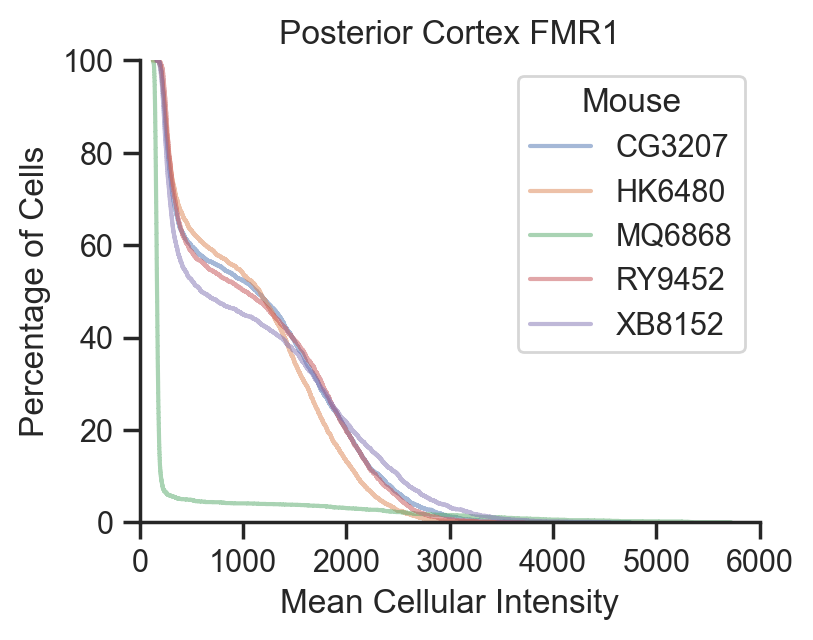

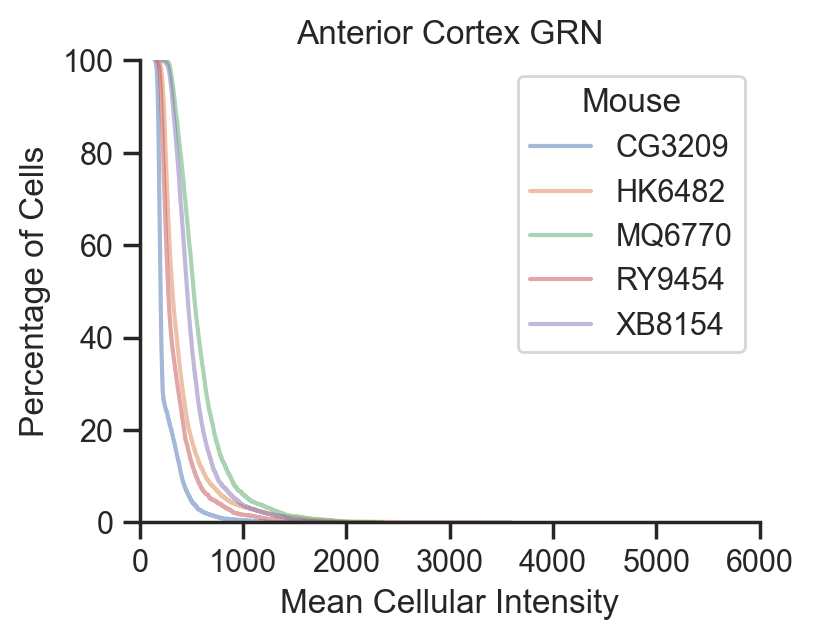

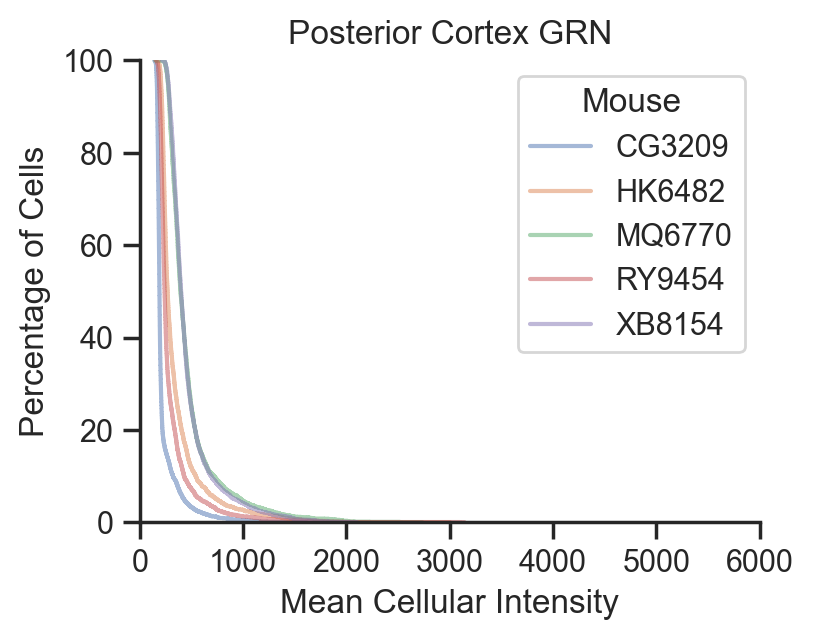

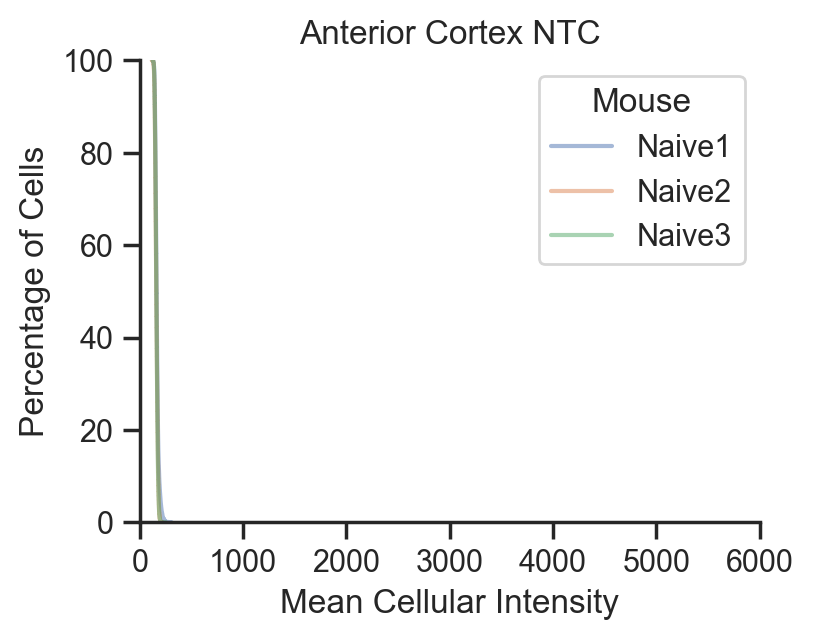

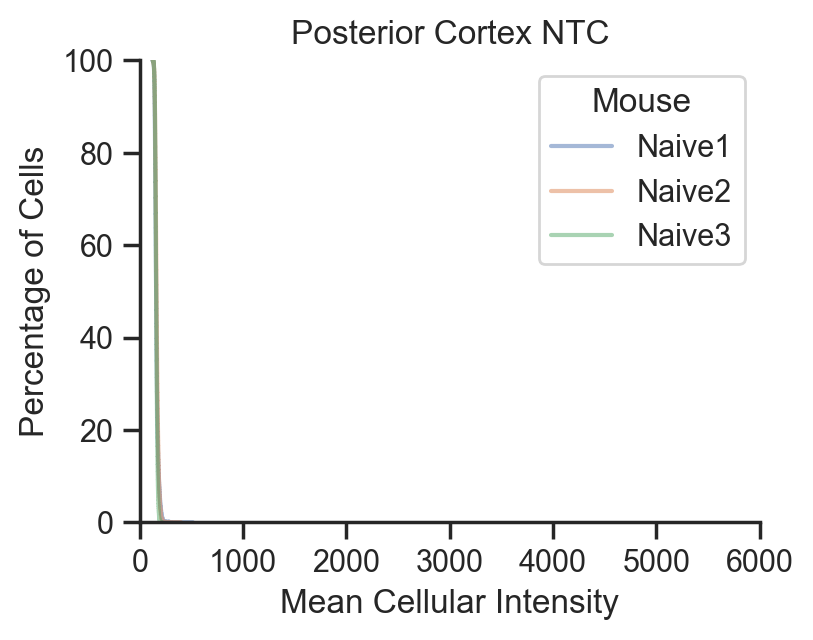

In [57]:
animalgoilist = ['FMR1', 'GRN','NTC']
for item in animalgoilist:
    print(item)
    data = dfStudyData_plot[(dfStudyData_plot['Cargo'].str.contains(item)) | (dfStudyData_plot['Cargo'] == 'Non-treated control')]

    for region in data['Brain Region'].unique():
        plt.figure(figsize=(4, 3), dpi=200)
        data1 = data[data['Brain Region'] == region]
        
        handles = []
        labels = []

        for animal in data['Animal'].unique():
            data2 = data1[data1['Animal'] == animal]
            print(animal)
            g = sns.ecdfplot(data = data2, x = 'Mean_HA', legend = False, alpha = 0.5, complementary = True)
            g.set_title(region + ' ' +item)
            g.set_ylabel('Percentage of Cells')
            g.set_yticklabels(range(0,120,20))
            sns.despine(top= True, right = True)
            g.set_xlabel('Mean Cellular Intensity')
            g.set_xlim(0,6000)
            handles.append(g.lines[-1])  # Get the last line added (corresponds to this animal)
            labels.append(animal)
        plt.legend(handles=handles, labels=labels, title='Animal')

        plt.savefig(savedir + '/Figures/' + item + '_' + region + '_Mean_HA.png' ,bbox_inches = 'tight')
       


In [126]:
FISHdf = FISHdf.merge(FISHmice, on = 'Animal')

In [123]:
FISHdir = "//pwcapdfs02.capsida.local/shares$/Histology/FISH/COHO-0626M/9July2029/Analysis/"

FMR1
GRN


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NTC


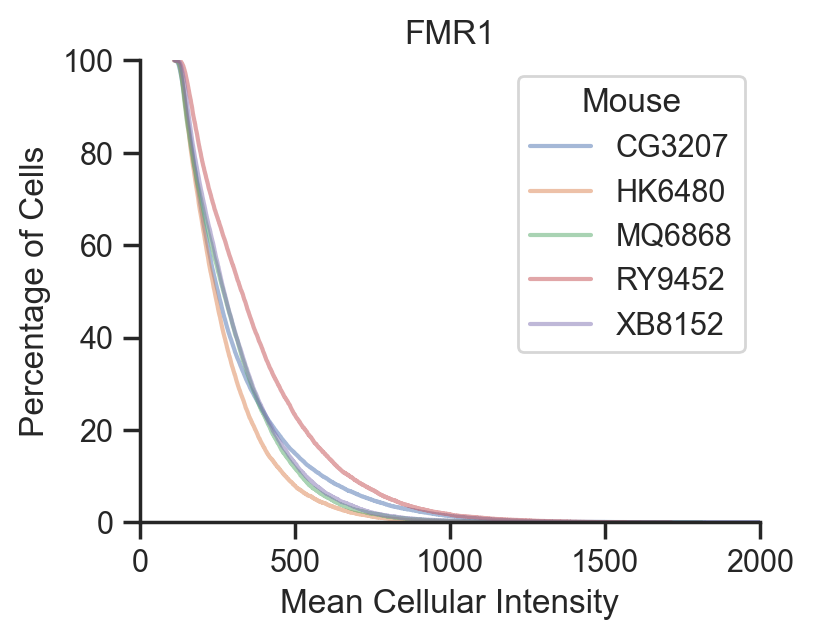

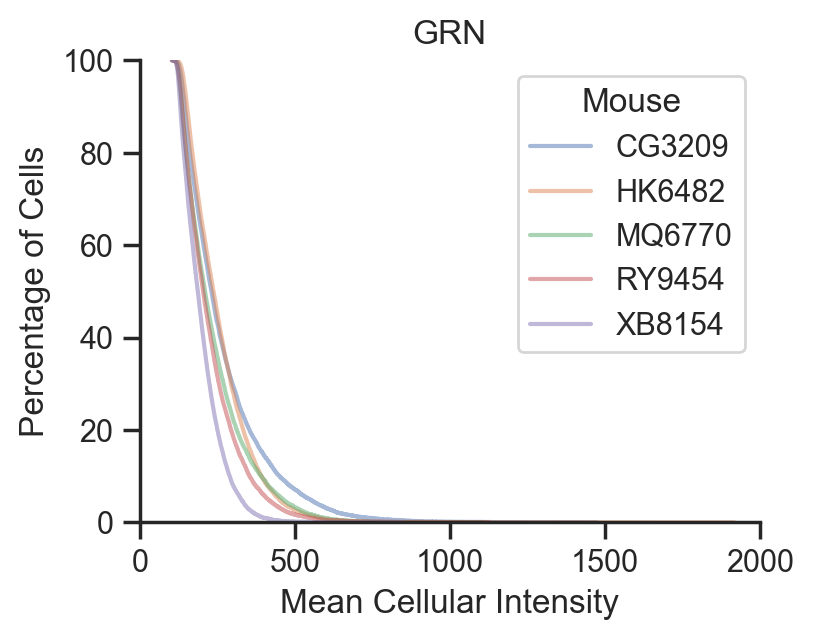

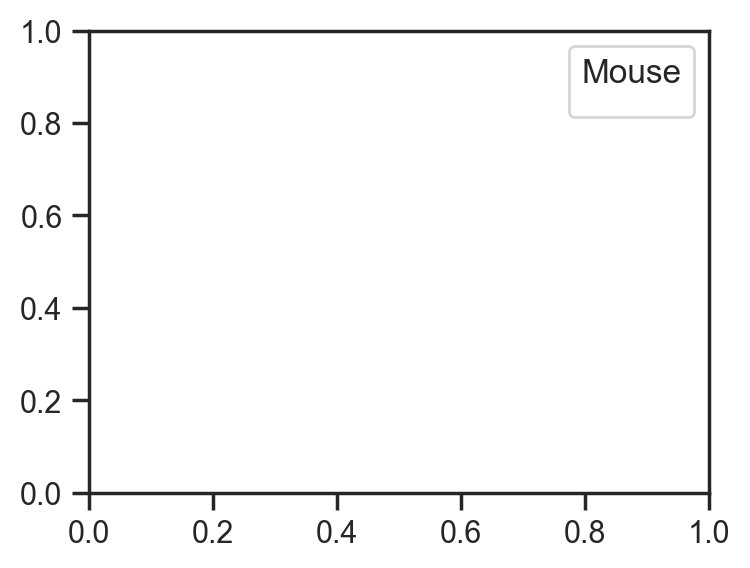

In [160]:
goilist = ['FMR1','GRN','NTC']

for item in goilist:
    print(item)
    data = FISHdf[(FISHdf['Cargo'].str.contains(item))| (FISHdf['Cargo'] == 'Non-treated control')]
    plt.figure(figsize = (4,3), dpi = 200)
    handles = []
    labels = []
    for animal in data['Animal'].unique():
        
        data1 = data[data['Animal'] == animal]
        
        
        
        #cm = cdict[data['Cargo'].unique().tolist()[0]]
        g = sns.ecdfplot(data = data1, x = 'AF568_FS43: Cell: Mean', legend = False, alpha = 0.5, complementary = True)
        g.set_title(item)
        g.set_ylabel('Percentage of Cells')
        g.set_yticklabels(range(0,120,20))
        sns.despine(top= True, right = True)
        g.set_xlabel('Mean Cellular Intensity')
        g.set_xlim(0,2000)
        handles.append(g.lines[-1])  # Get the last line added (corresponds to this animal)
        labels.append(animal)
    plt.legend(handles=handles, labels=labels, title= 'Animal')
    plt.savefig(FISHdir + '/Figures/'  + item + '_' + region + '_Mean_HA.png' ,bbox_inches = 'tight')

FMR1
GRN


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NTC


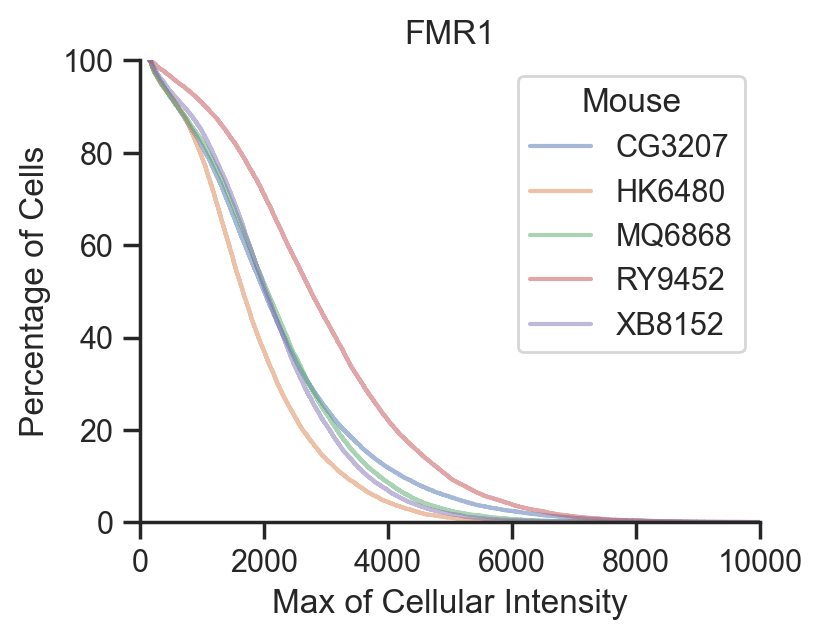

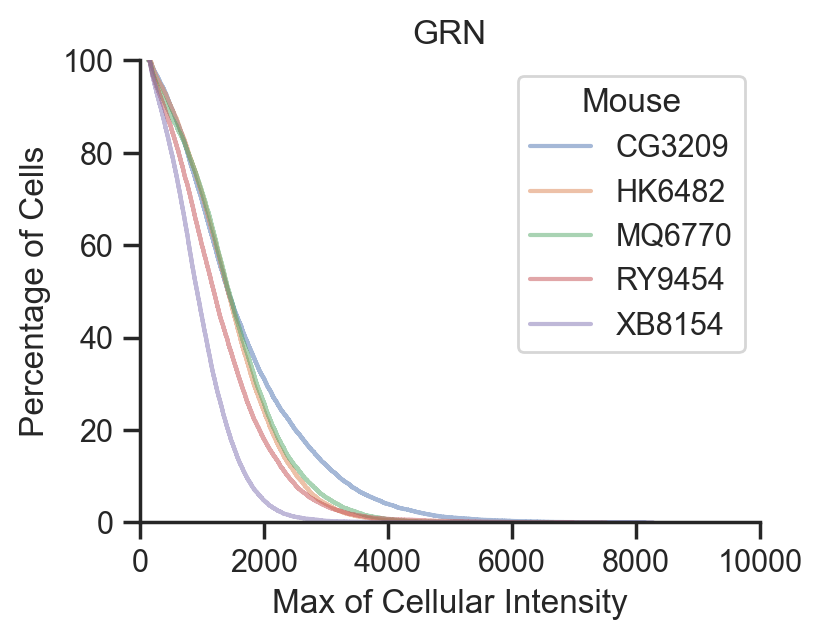

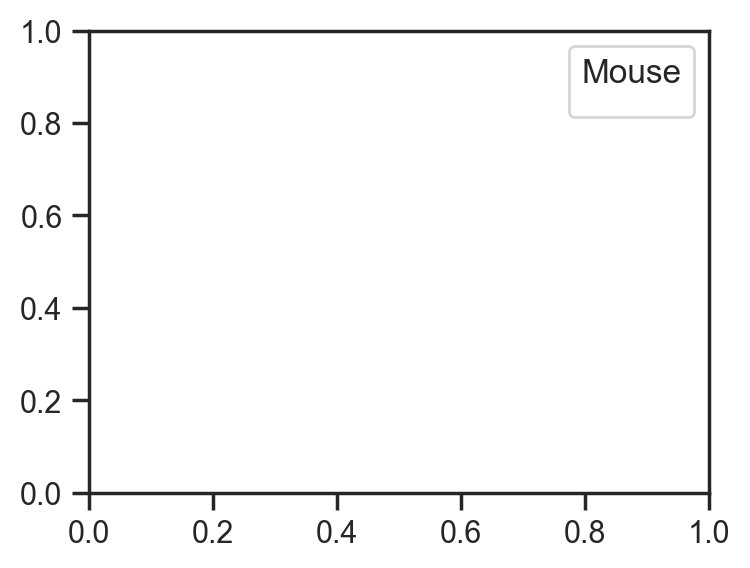

In [168]:
measure = 'Max'

goilist = ['FMR1','GRN','NTC']

for item in goilist:
    print(item)
    data = FISHdf[(FISHdf['Cargo'].str.contains(item))| (FISHdf['Cargo'] == 'Non-treated control')]
    plt.figure(figsize = (4,3), dpi = 200)
    handles = []
    labels = []
    for animal in data['Animal'].unique():
        
        data1 = data[data['Animal'] == animal]
        
        
        
        #cm = cdict[data['Cargo'].unique().tolist()[0]]
        g = sns.ecdfplot(data = data1, x = 'AF568_FS43: Cell: '+measure, legend = False, alpha = 0.5, complementary = True)
        g.set_title(item)
        g.set_ylabel('Percentage of Cells')
        g.set_yticklabels(range(0,120,20))
        sns.despine(top= True, right = True)
        g.set_xlabel(measure + ' of Cellular Intensity')
        g.set_xlim(0,10000)
        #g.set_xscale('log')
        handles.append(g.lines[-1])  # Get the last line added (corresponds to this animal)
        labels.append(animal)
    plt.legend(handles=handles, labels=labels, title= 'Animal')
    plt.savefig(FISHdir + '/Figures/'  + item + '_' + region + measure + '_RBFOX3.png' ,bbox_inches = 'tight')

FMR1
GRN


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NTC


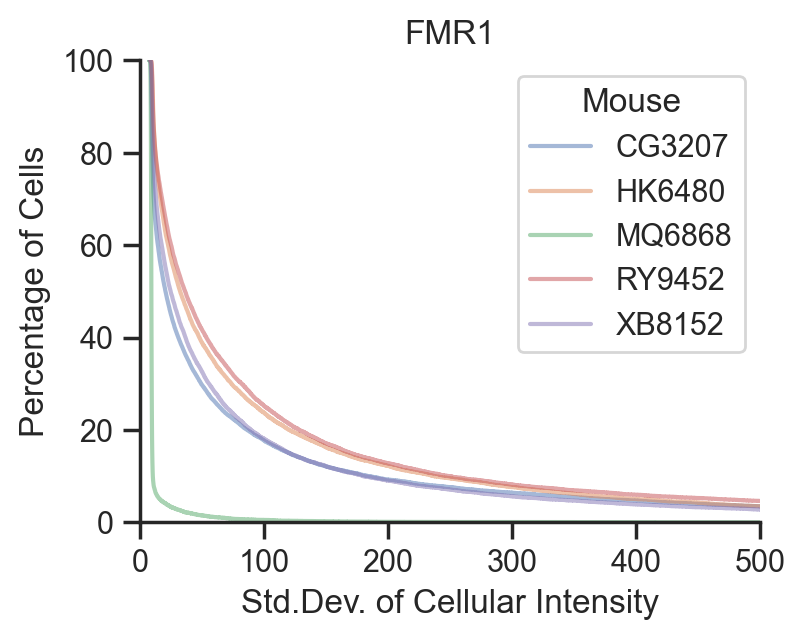

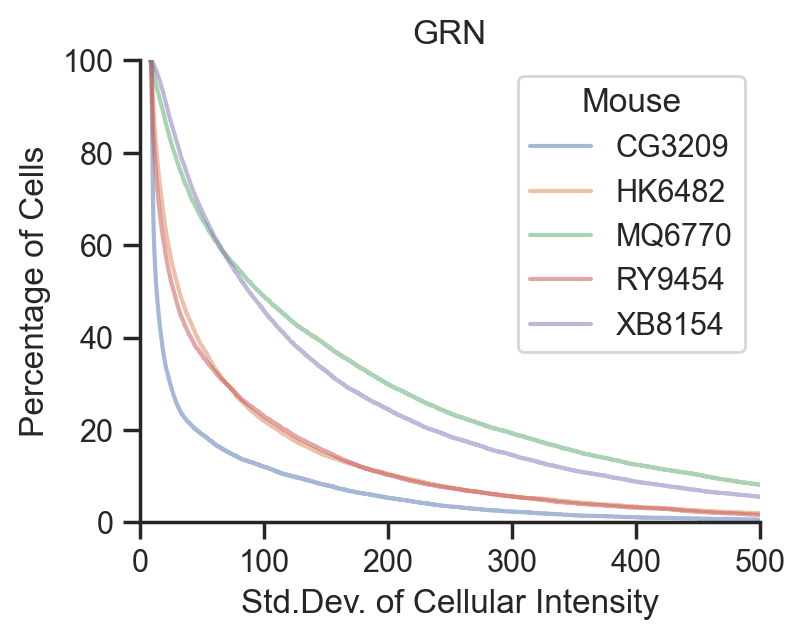

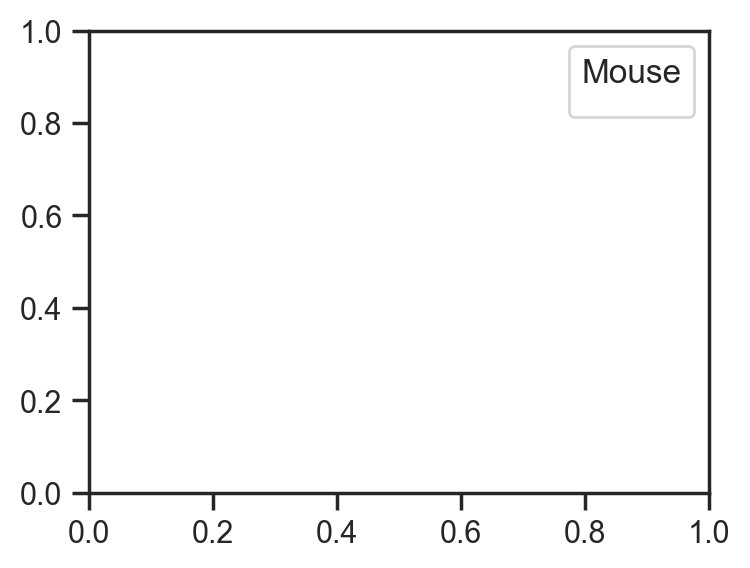

In [165]:
measure = 'Std.Dev.'

goilist = ['FMR1','GRN','NTC']

for item in goilist:
    print(item)
    data = FISHdf[(FISHdf['Cargo'].str.contains(item))| (FISHdf['Cargo'] == 'Non-treated control')]
    plt.figure(figsize = (4,3), dpi = 200)
    handles = []
    labels = []
    for animal in data['Animal'].unique():
        
        data1 = data[data['Animal'] == animal]
        
        
        
        #cm = cdict[data['Cargo'].unique().tolist()[0]]
        g = sns.ecdfplot(data = data1, x = 'AF647: Cell: '+measure, legend = False, alpha = 0.5, complementary = True)
        g.set_title(item)
        g.set_ylabel('Percentage of Cells')
        g.set_yticklabels(range(0,120,20))
        sns.despine(top= True, right = True)
        g.set_xlabel(measure + ' of Cellular Intensity')
        g.set_xlim(0,500)
        #g.set_xscale('log')
        handles.append(g.lines[-1])  # Get the last line added (corresponds to this animal)
        labels.append(animal)
    plt.legend(handles=handles, labels=labels, title= 'Animal')
    plt.savefig(FISHdir + '/Figures/'  + item + '_' + region + measure + '_WPRE.png' ,bbox_inches = 'tight')

FMR1
GRN
NTC


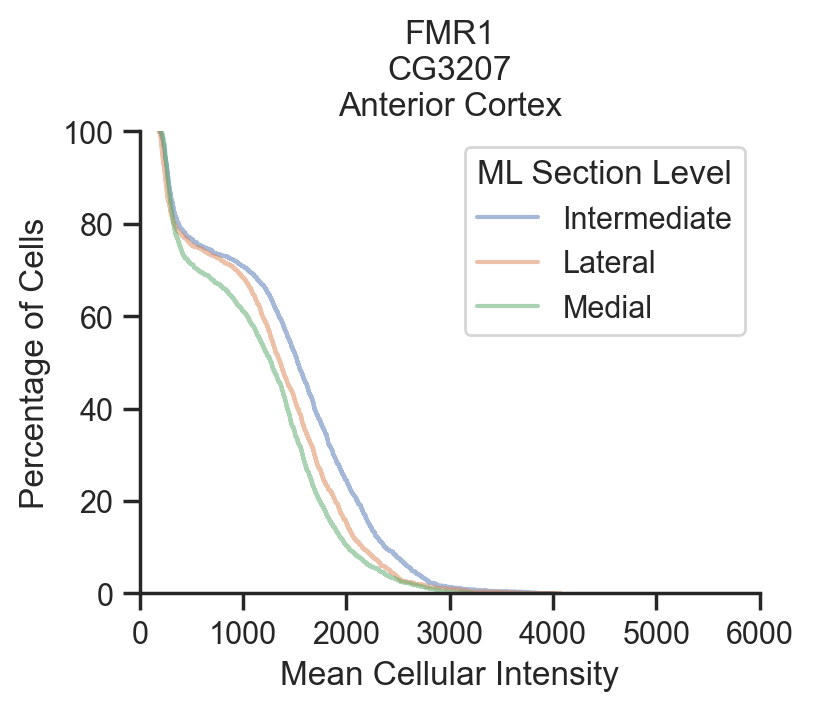

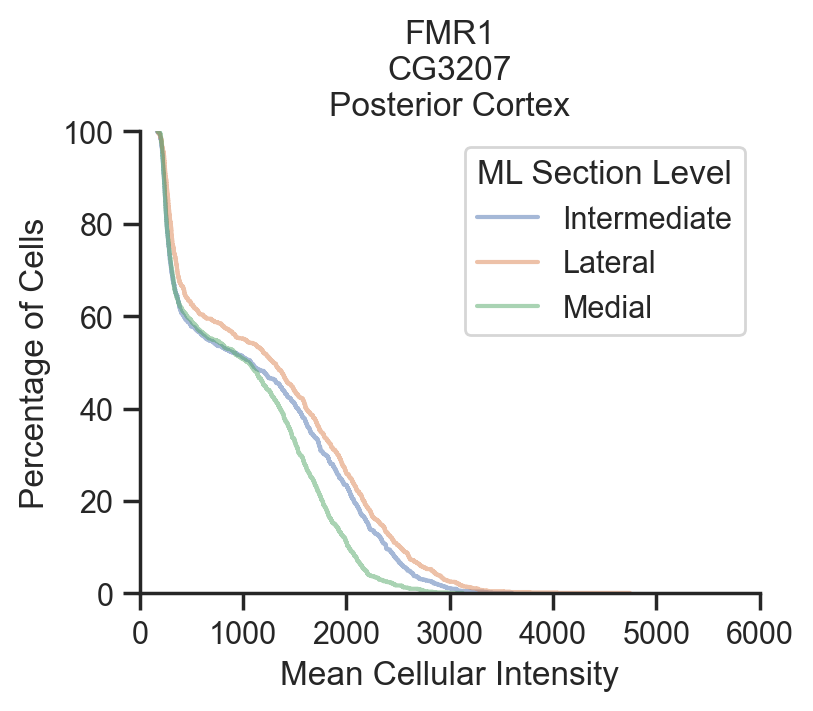

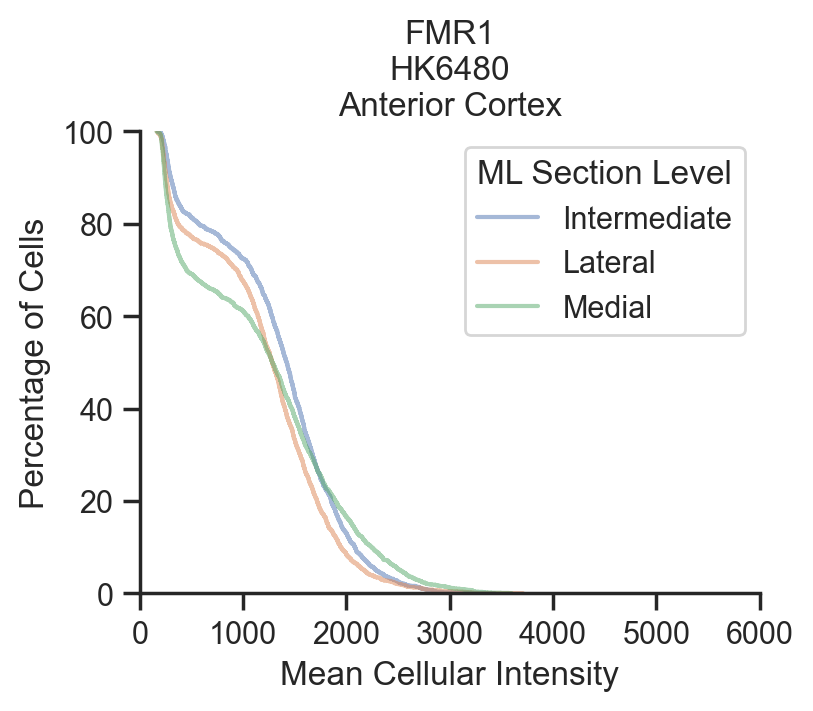

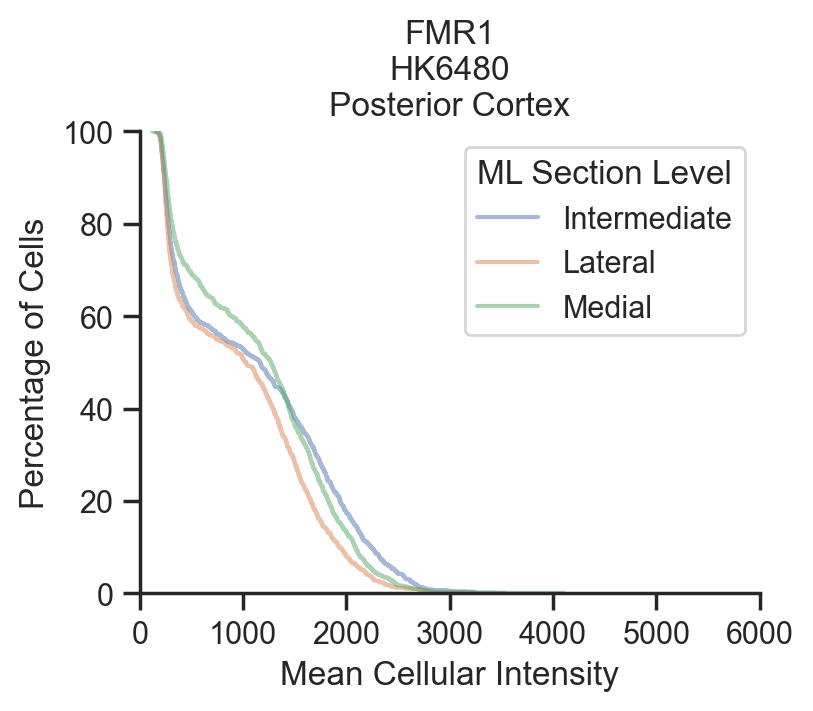

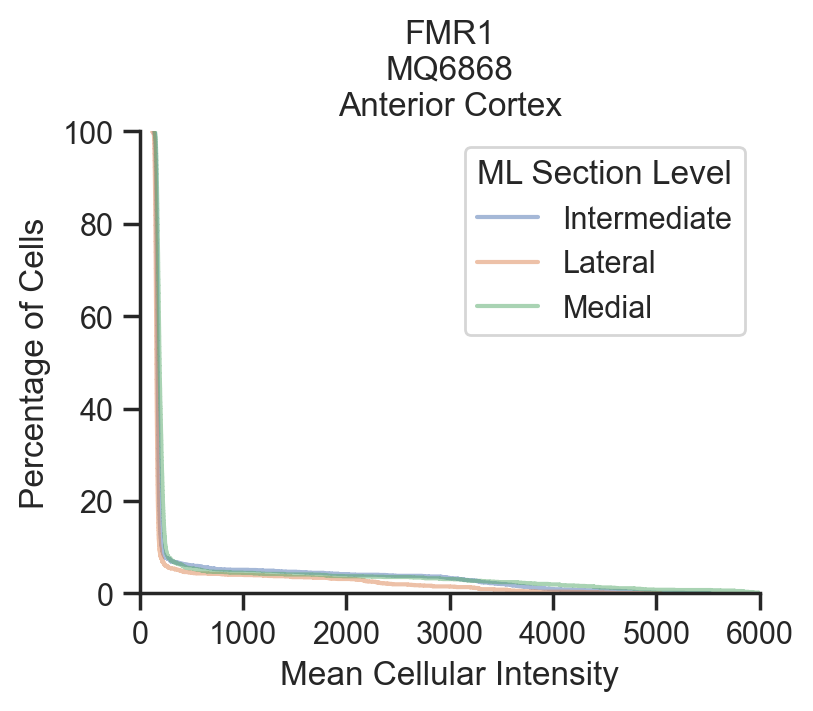

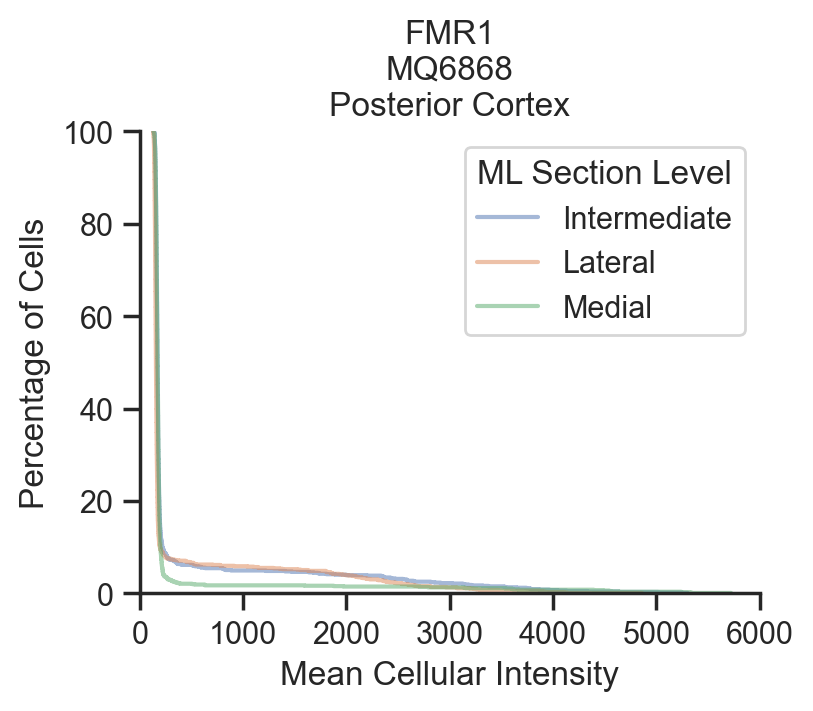

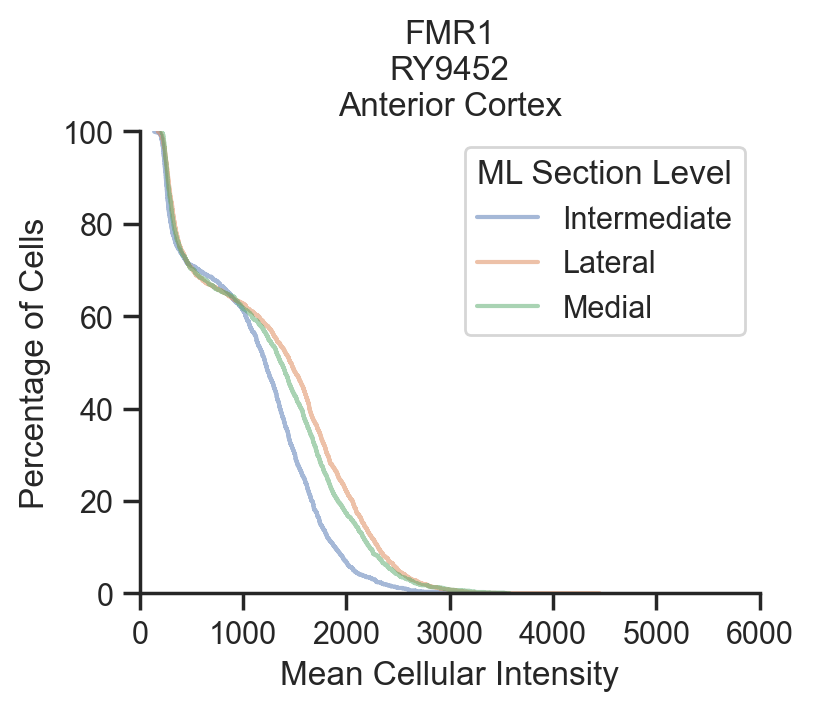

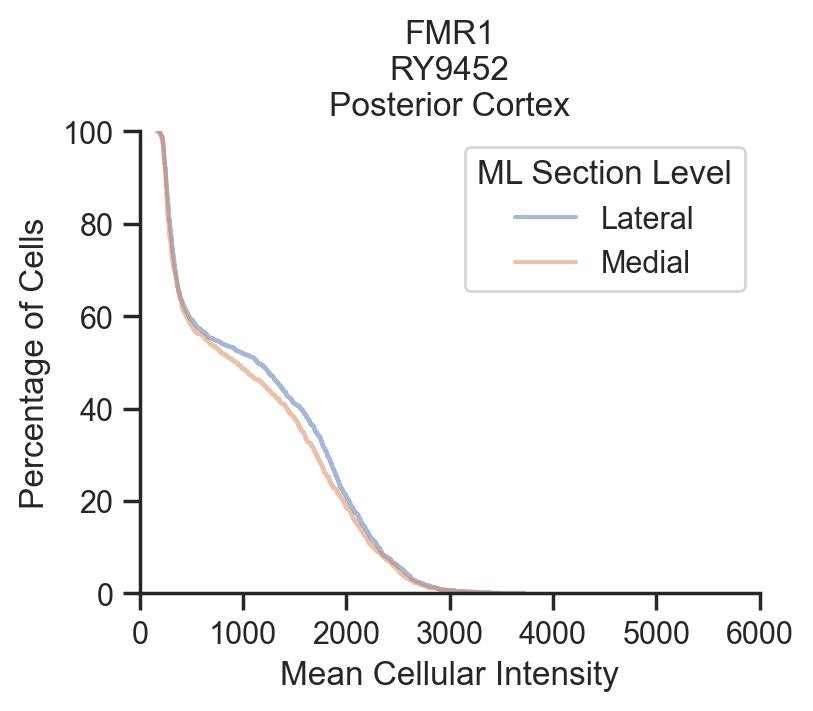

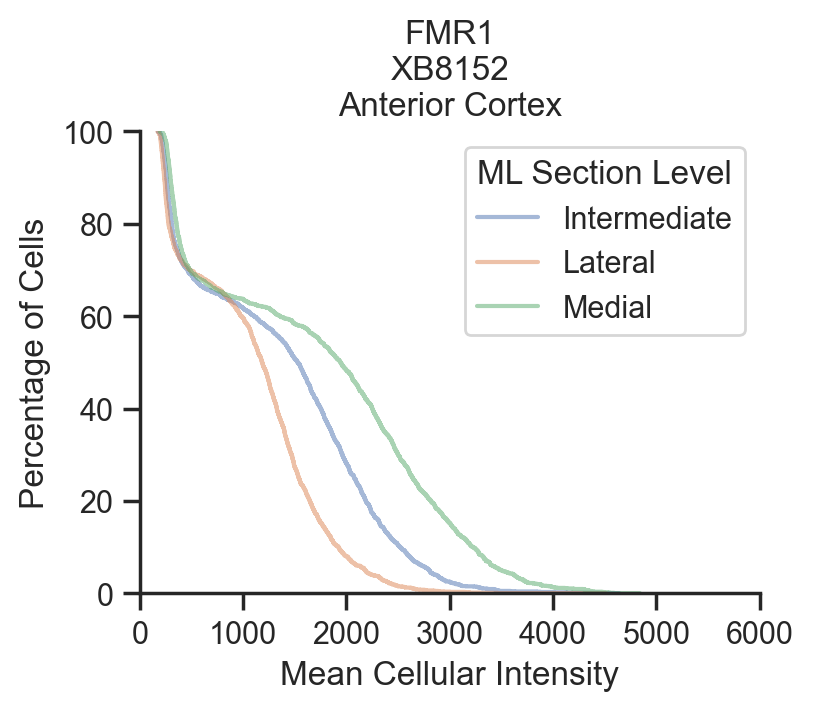

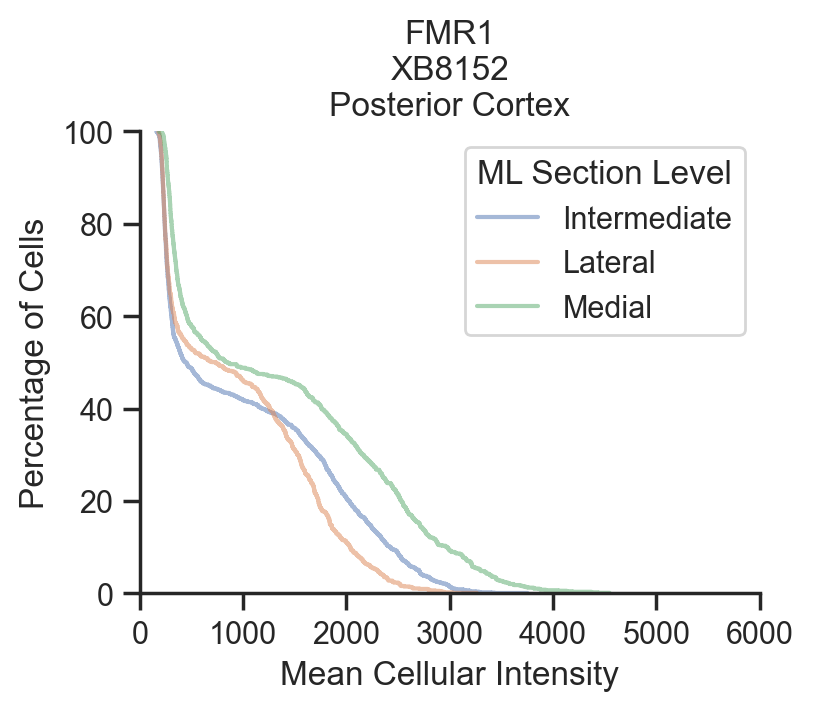

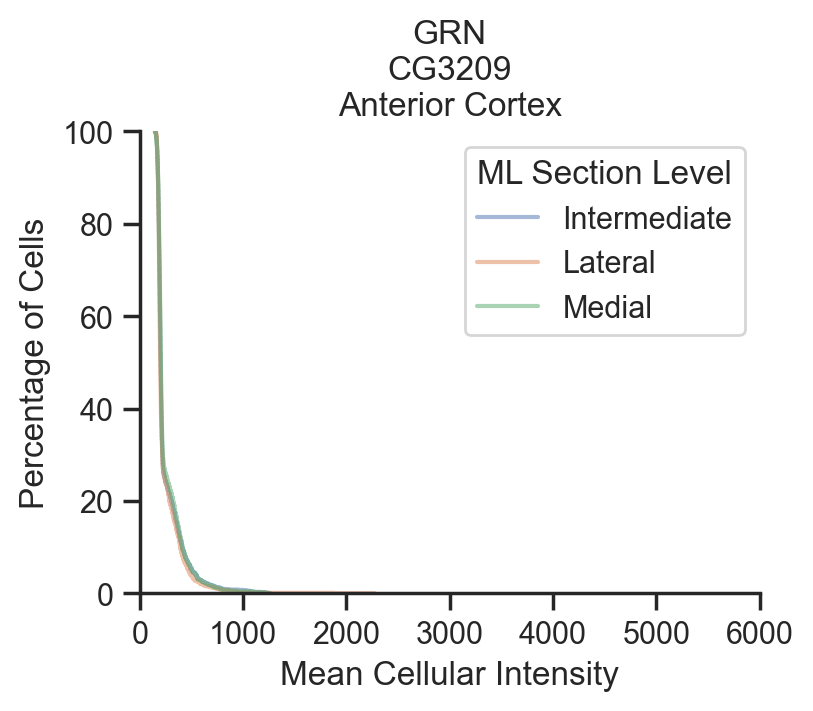

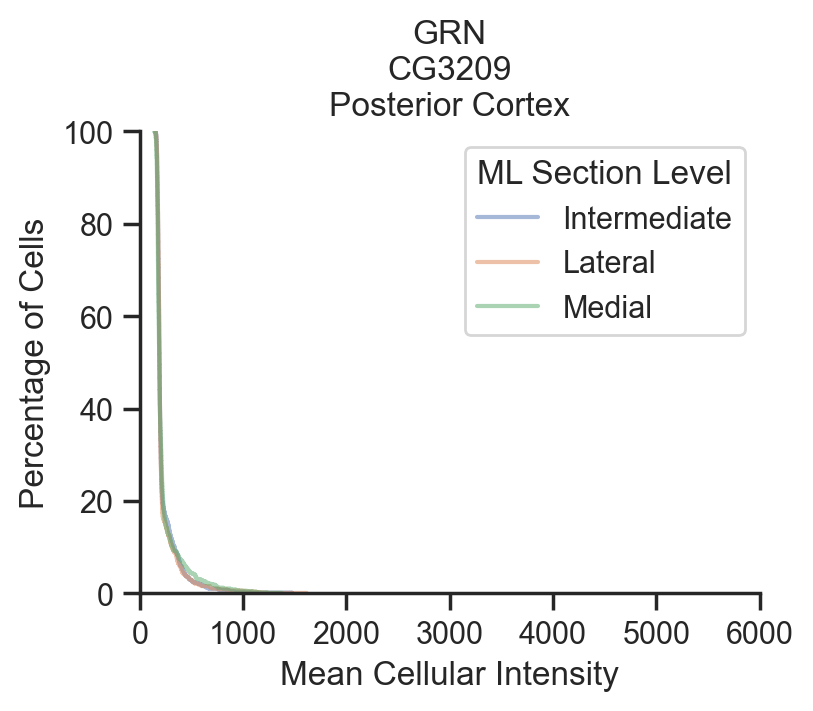

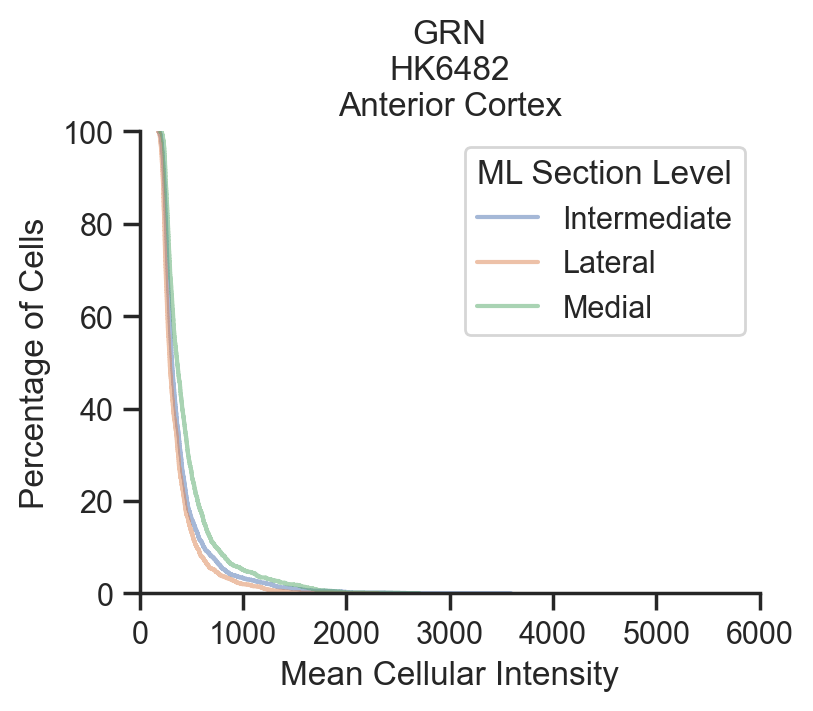

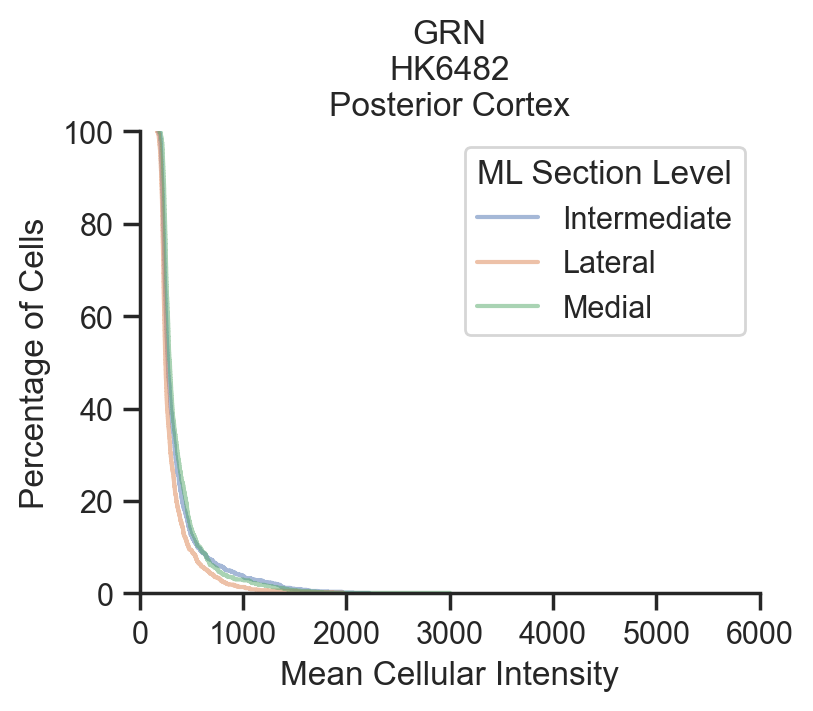

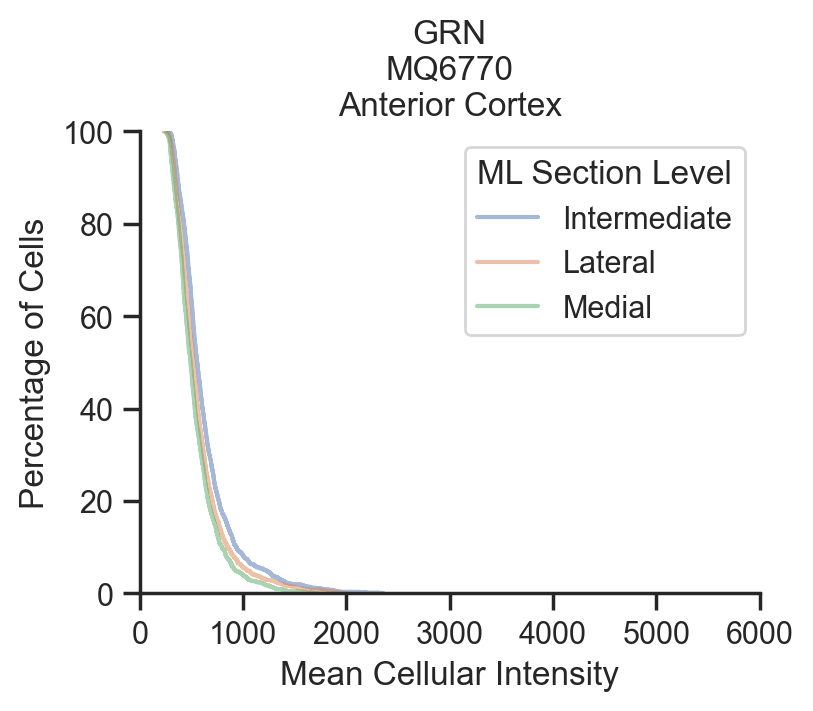

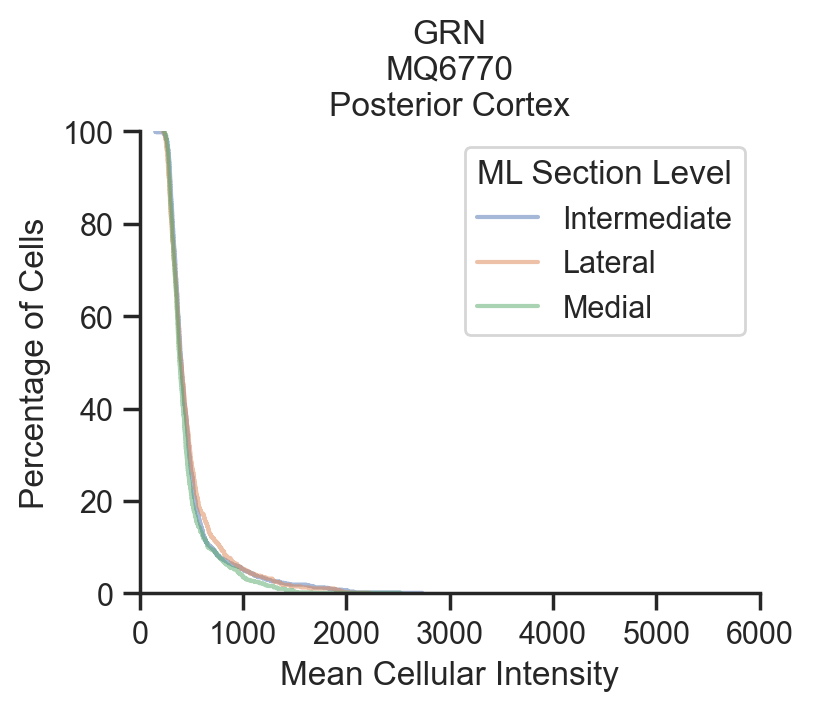

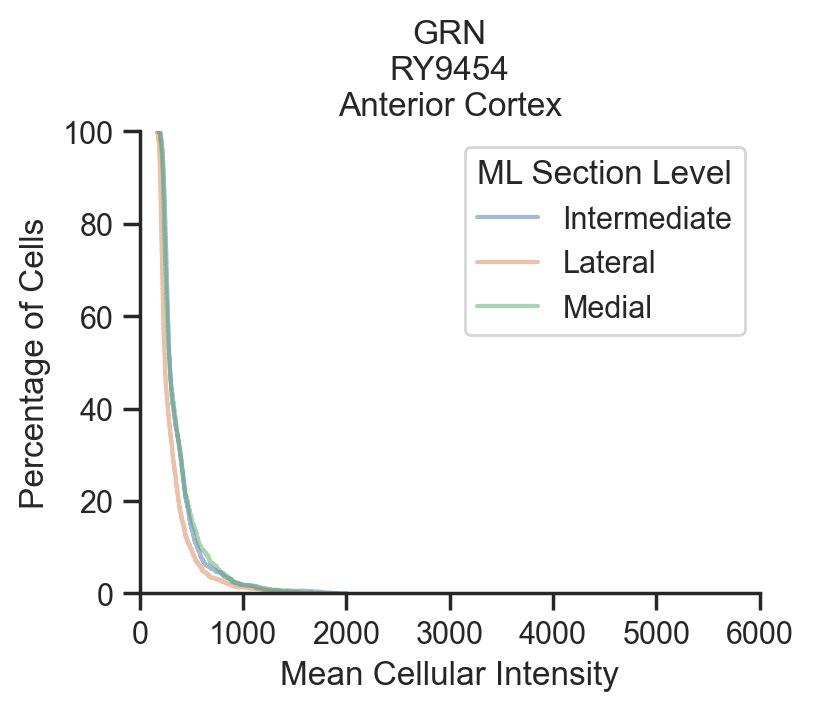

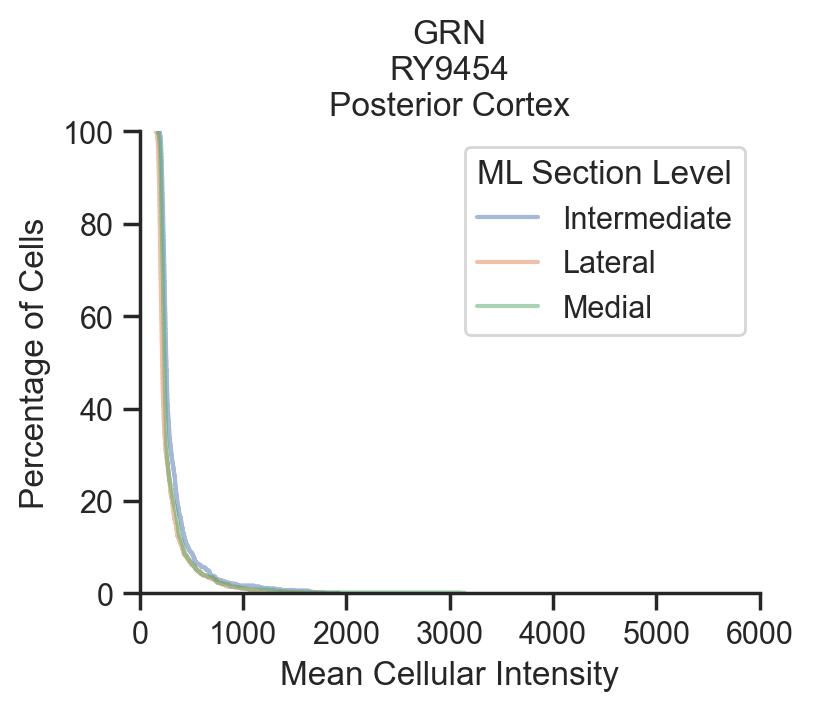

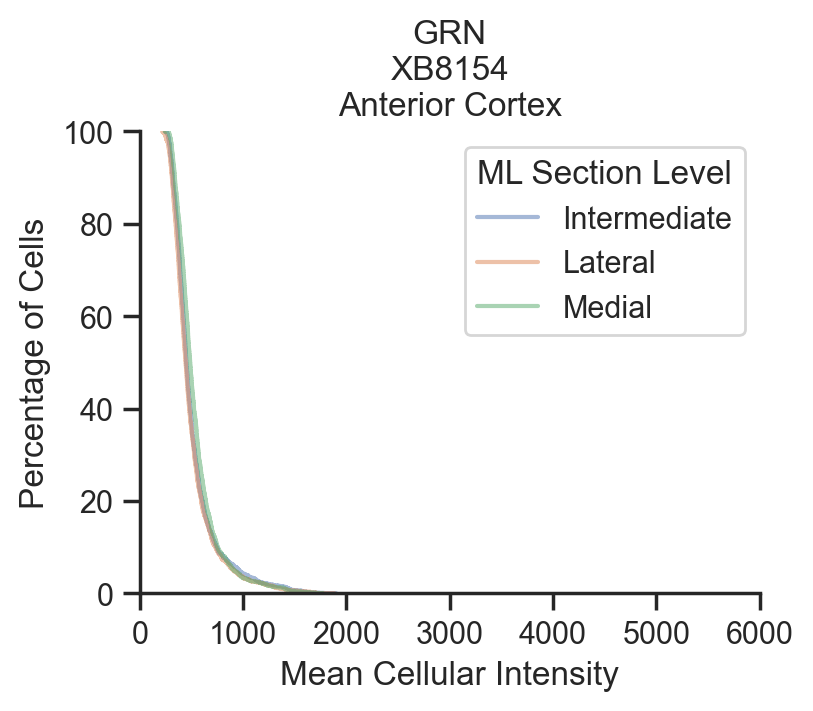

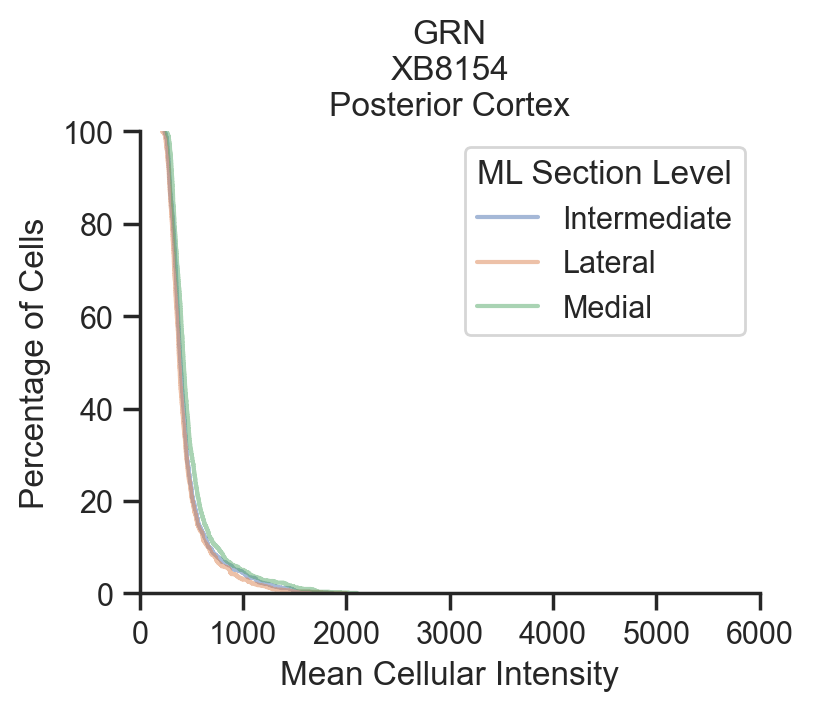

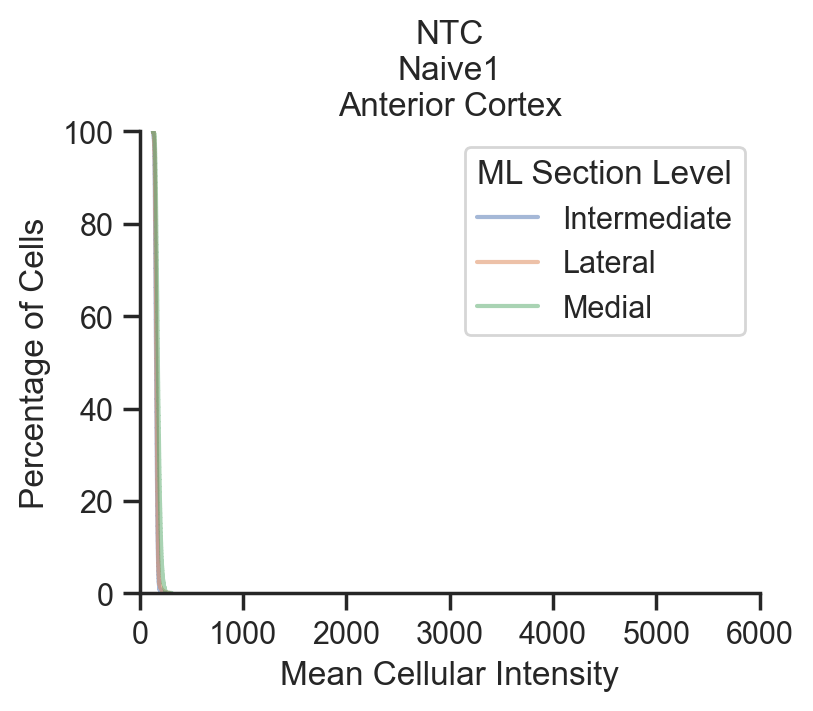

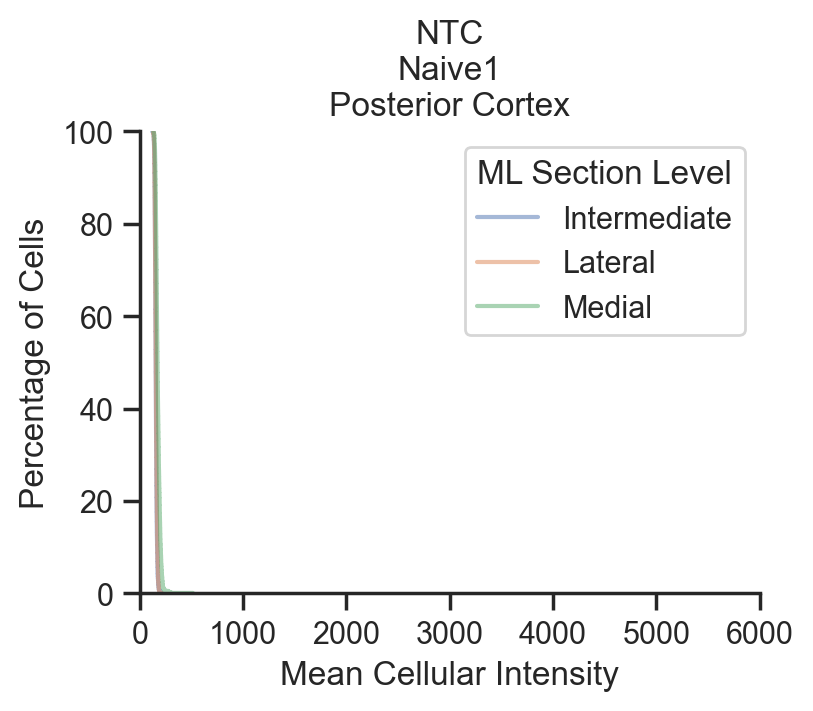

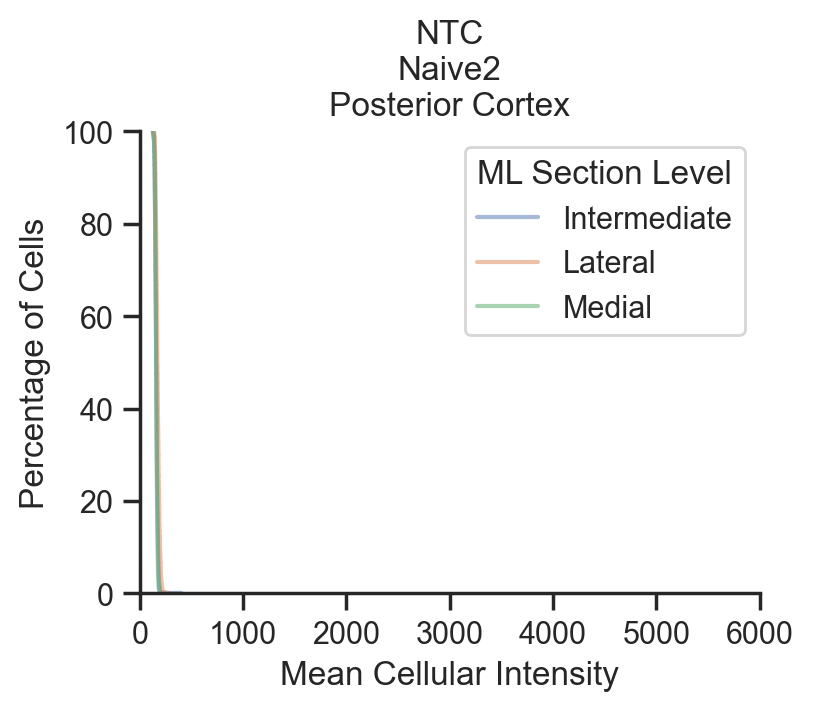

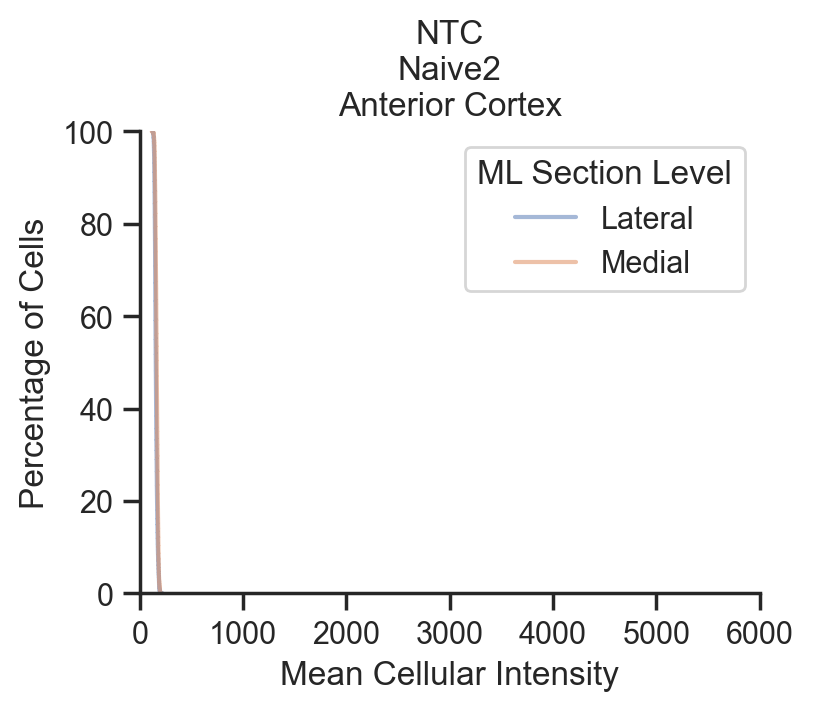

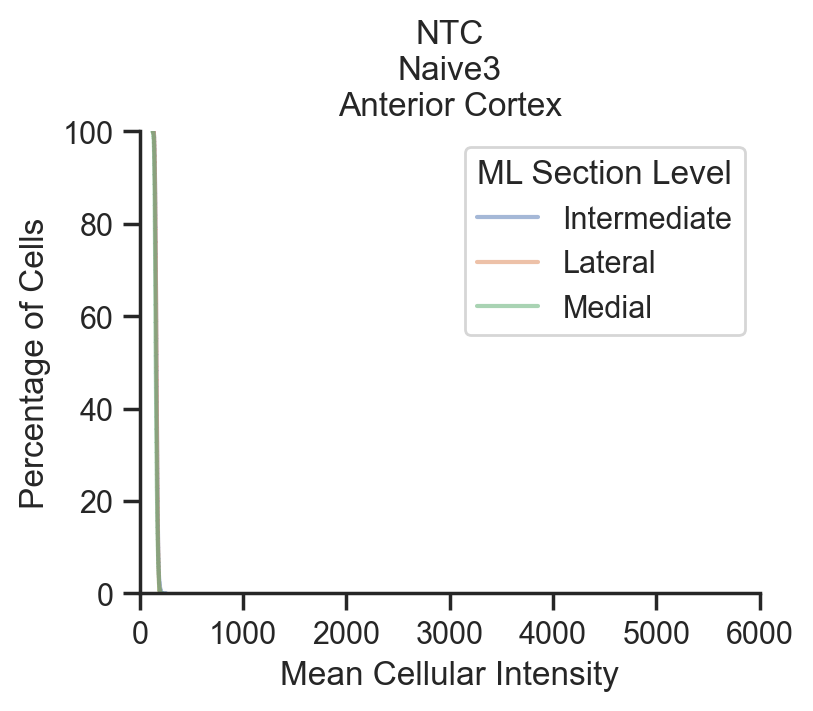

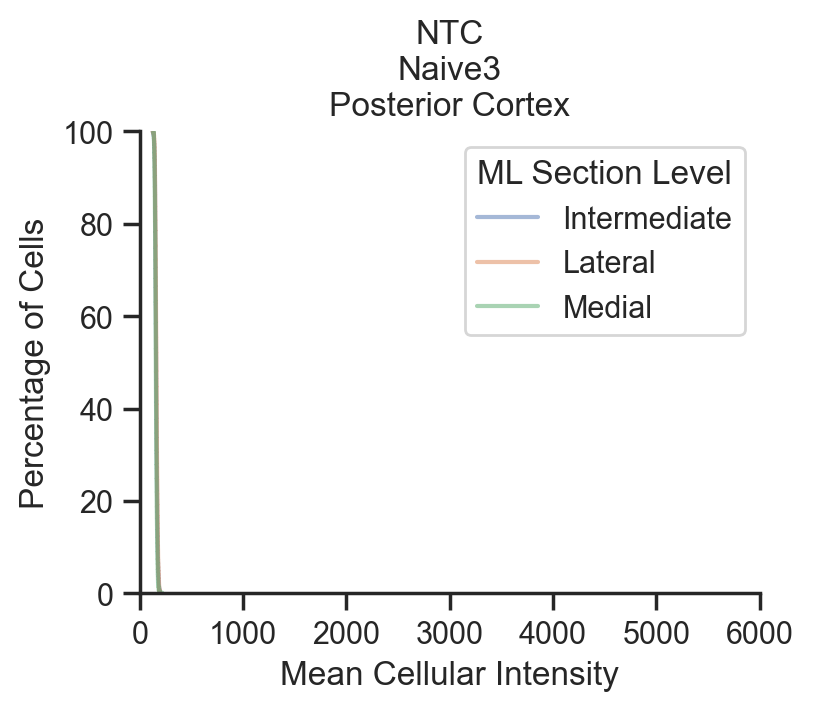

In [66]:
goilist = ['FMR1','GRN', 'NTC']
for item in goilist:
    print(item)
    data = dfStudyData_plot[(dfStudyData_plot['Cargo'].str.contains(item))| (dfStudyData_plot['Cargo'] == 'Non-treated control')]
   
    for animal in data['Animal'].unique():
        
        data1 = data[data['Animal'] == animal]
       
        for region in data1['Brain Region'].unique():
            plt.figure(figsize = (4,3), dpi = 200)
            data2 = data1[data1['Brain Region'] == region]
            handles = []
            labels = []
            
            for image in data2['Image'].unique():

                
                if int(image[image.find('-')+1:image.find('-')+2]) == 7:
                    level = 'Medial'
                elif int(image[image.find('-')+1:image.find('-')+2]) == 2:
                    level = 'Intermediate'
                elif int(image[image.find('-')+1:image.find('-')+2]) == 4:
                    level = 'Lateral'
                    

                data3 = data2[data2['Image'] == image]
                #cm = cdict[data['Cargo'].unique().tolist()[0]]
                g = sns.ecdfplot(data = data3, x = 'Mean_HA', legend = False, alpha = 0.5, complementary = True)
                g.set_title(item + '\n' + animal + '\n' + region)
                g.set_ylabel('Percentage of Cells')
                g.set_yticklabels(range(0,120,20))
                sns.despine(top= True, right = True)
                g.set_xlabel('Mean Cellular Intensity')
                g.set_xlim(0,6000)
                handles.append(g.lines[-1])  # Get the last line added (corresponds to this animal)
                labels.append(level)
            plt.legend(handles=handles, labels=labels, title= 'ML Section Level')
            plt.savefig(savedir + '/Figures/animalLevel/'  + item + '_' + animal + '_' + region + '_Mean_HA.png' ,bbox_inches = 'tight')

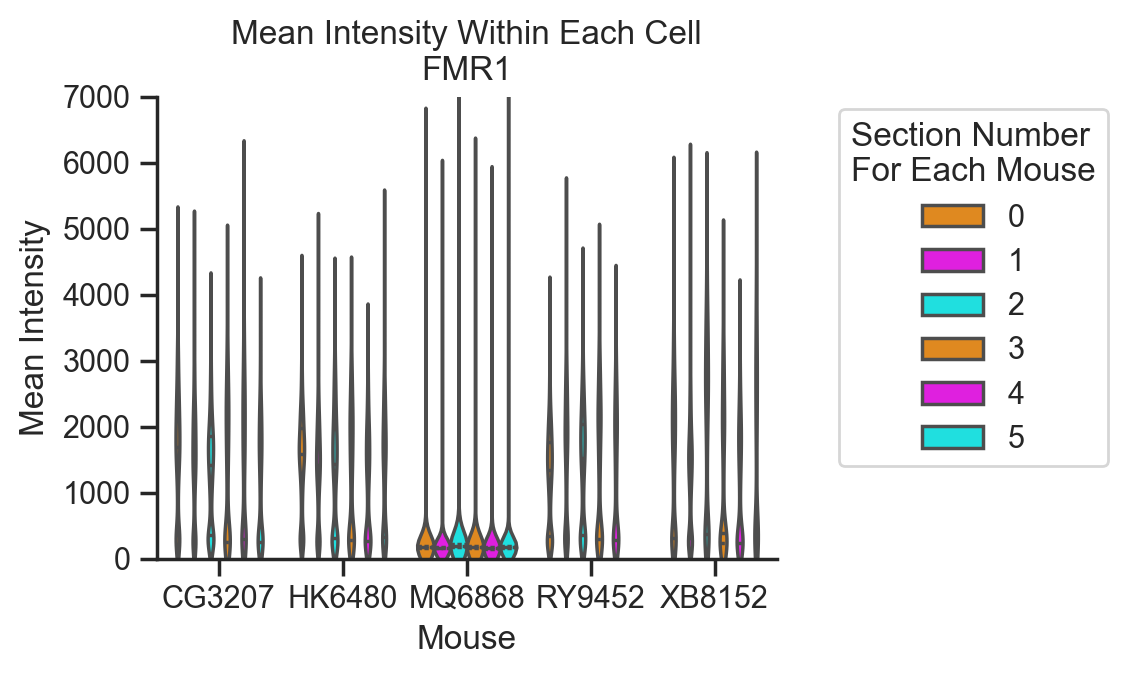

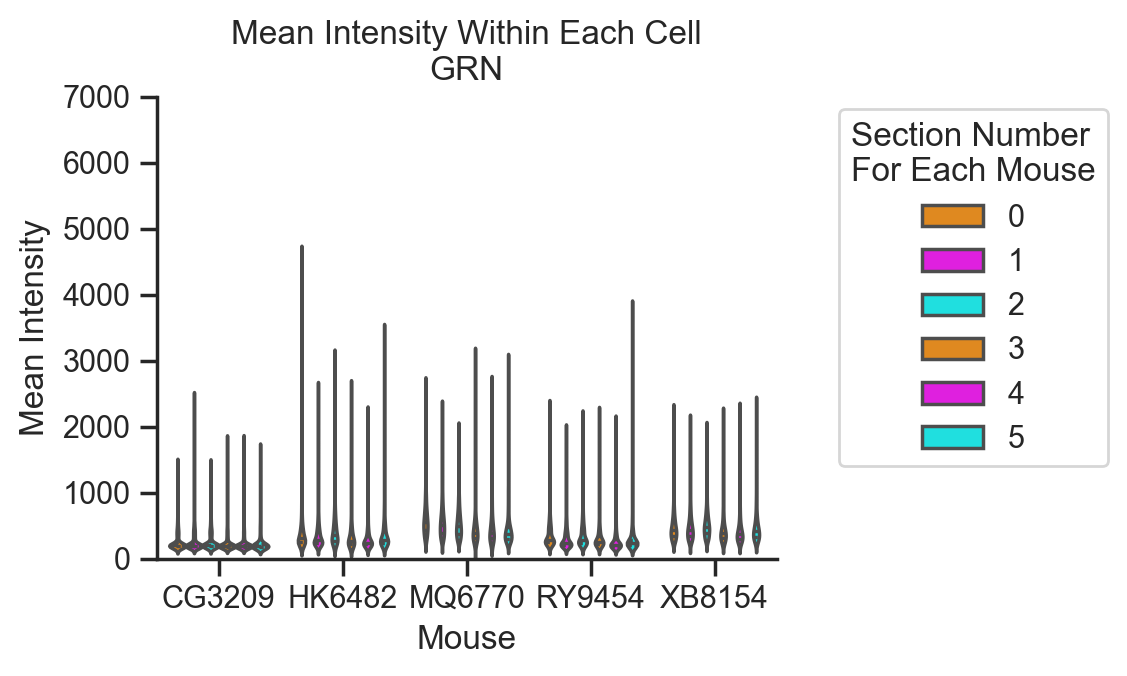

In [37]:
metric = 'Mean'
compartment = '_Nuc'
for group in dfStudyData_plot['Cargo'].unique().tolist():
    plt.figure(figsize = (4,3),dpi=200)
    data = dfStudyData_plot[dfStudyData_plot['Cargo'].isin([group])].copy()
    
    g = sns.violinplot(data, x= 'Animal', y='Mean_Nuc', hue = 'Section Number', palette = ['darkorange','magenta','cyan'], inner = 'quart')
    sns.despine(top = True, right = True)
    g.set_ylabel('Mean Intensity')
    plt.title('Mean Intensity Within Each Cell/n'+group)
    #plt.xticks(rotation=45,fontsize=8)
    g.set_ylim(0,7000)
    plt.legend(loc=[1.1,0.2], title = 'Section Number\nFor Each animal')
    plt.savefig(savedir + '/Figures/Cortex_NeuN_AllSections_violinplot_' + metric + compartment + group + '.png', bbox_inches = 'tight')

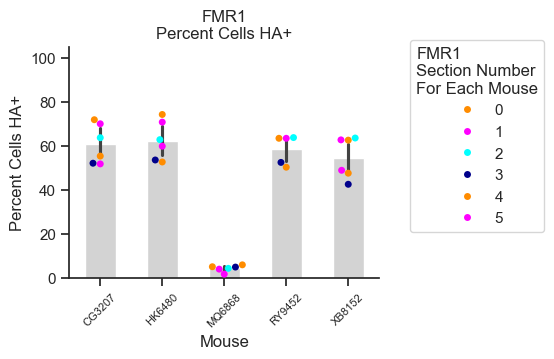

In [163]:
metric = 'Mean'
compartment = '_Nuc'
for cargo,df1 in percentcells.groupby('Cargo'):

    plt.figure(figsize = (4,3),dpi=100)
    data = df1
    g = sns.swarmplot(data, x= 'Animal', y='Mean_Nuc', hue = 'Section Number', palette = ['darkorange','magenta','cyan', 'darkblue'],)
    g = sns.barplot(data, x= 'Animal', y='Mean_Nuc', color = 'lightgray',width=0.5)
    sns.despine(top = True, right = True)
    g.set_ylabel('Percent Cells HA+')
    plt.title(cargo + '\nPercent Cells HA+')
    plt.xticks(rotation=45,fontsize=8)
    g.set_ylim(0,105)
    plt.legend(loc=[1.1,0.2], title = df1['Cargo'].iloc[0] + '\nSection Number\nFor Each animal')
    break
    plt.savefig(savedir + '/Figures/'+wave+ 'Cortex_AllSections_NeuN' + group + 'PerCellIntensityBoxPlot' + metric + compartment + '.png' ,bbox_inches = 'tight')

In [86]:
percentcells = percentcells.replace(np.nan,0).copy()

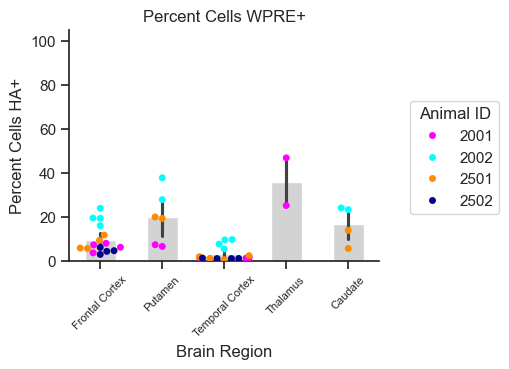

In [235]:
metric = 'Mean'
compartment = '_HA'

plt.figure(figsize = (4,3),dpi=100)
data = percentcells

g = sns.swarmplot(data, x= 'Brain Region', y='Mean_WPRE', hue = 'Animal', palette = ['magenta','cyan', 'darkorange','darkblue'],)
g = sns.barplot(data, x= 'Brain Region', y='Mean_WPRE', color = 'lightgray',width=0.5)
sns.despine(top = True, right = True)
g.set_ylabel('Percent Cells HA+')
plt.title('Percent Cells WPRE+')
plt.xticks(rotation=45,fontsize=8)
g.set_ylim(0,105)
plt.legend(loc=[1.1,0.2], title = 'Animal ID')
#plt.savefig(savedir + '/Figures/Cortex_AllSections_NeuN' + group + 'PerCellIntensityBoxPlot' + metric + compartment + str(HAthresh) + 'thresh.png' ,bbox_inches = 'tight')

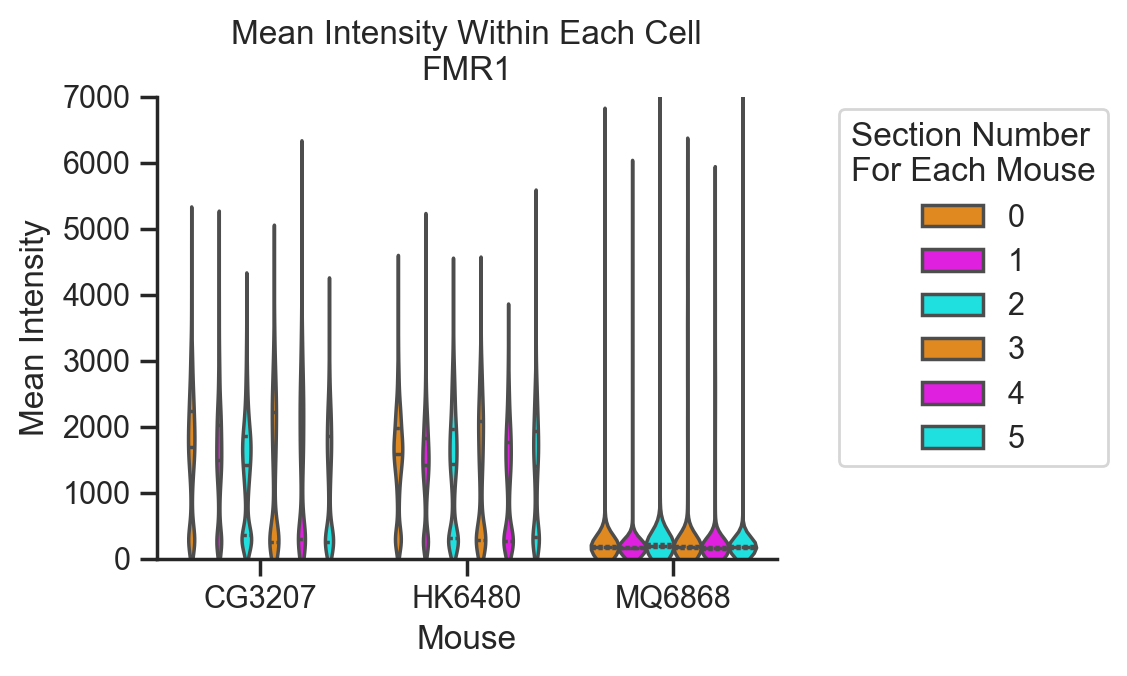

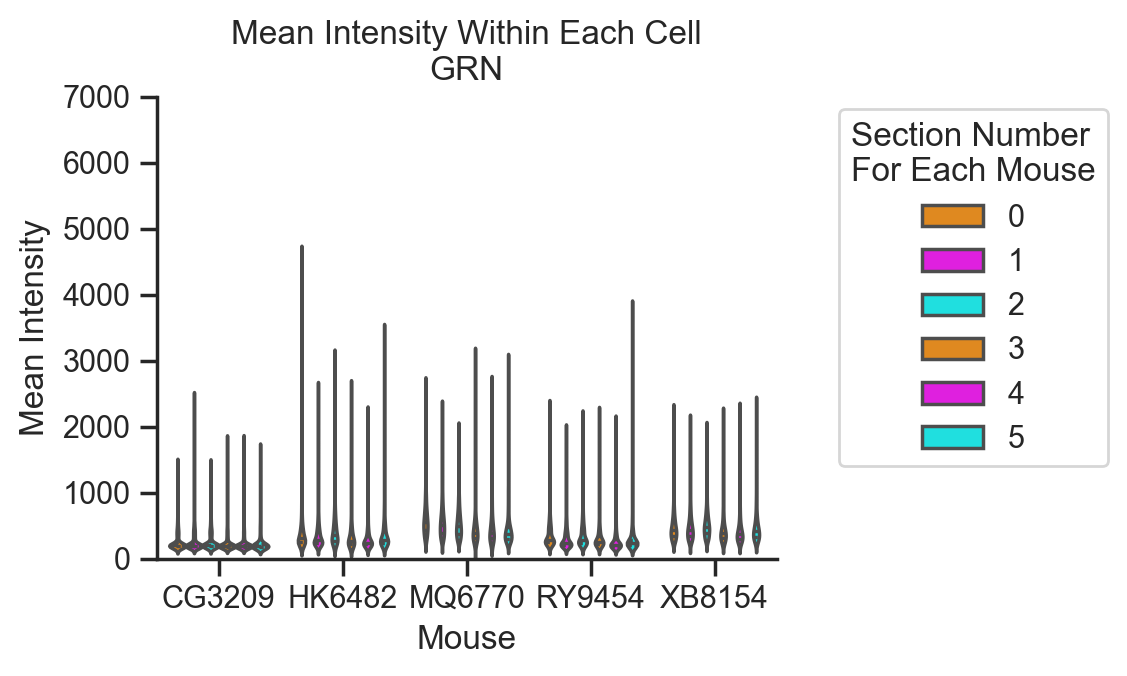

In [62]:
metric = 'Mean'
compartment = '_Nuc'
for group in dfStudyData_plot['Cargo'].unique().tolist():
    plt.figure(figsize = (4,3),dpi=200)
    data = dfStudyData_plot[dfStudyData_plot['Cargo'].isin([group])].copy()
    
    g = sns.violinplot(data, x= 'Animal', y='Mean_Nuc', hue = 'Section Number', palette = ['darkorange','magenta','cyan'], inner = 'quart')
    sns.despine(top = True, right = True)
    g.set_ylabel('Mean Intensity')
    plt.title('Mean Intensity Within Each Cell\n'+group)
    #plt.xticks(rotation=45,fontsize=8)
    g.set_ylim(0,7000)
    plt.legend(loc=[1.1,0.2], title = 'Section Number\nFor Each animal')

In [73]:
dfStudyData_plot['Cargo'].value_counts()

De-Anonymized Construct
Prevail_optGRN         61851
Prevail_optFMR1        61689
Capsida_optGRN         61124
Prevail_wtGRN          57253
Capsida_wtGRN          57008
Capsida_optFMR1        55707
Prevail_wtFMR1         55649
Capsida_wtFMR1         54225
Non-treated control    41680
Name: count, dtype: int64

UnboundLocalError: local variable 'boxprops' referenced before assignment

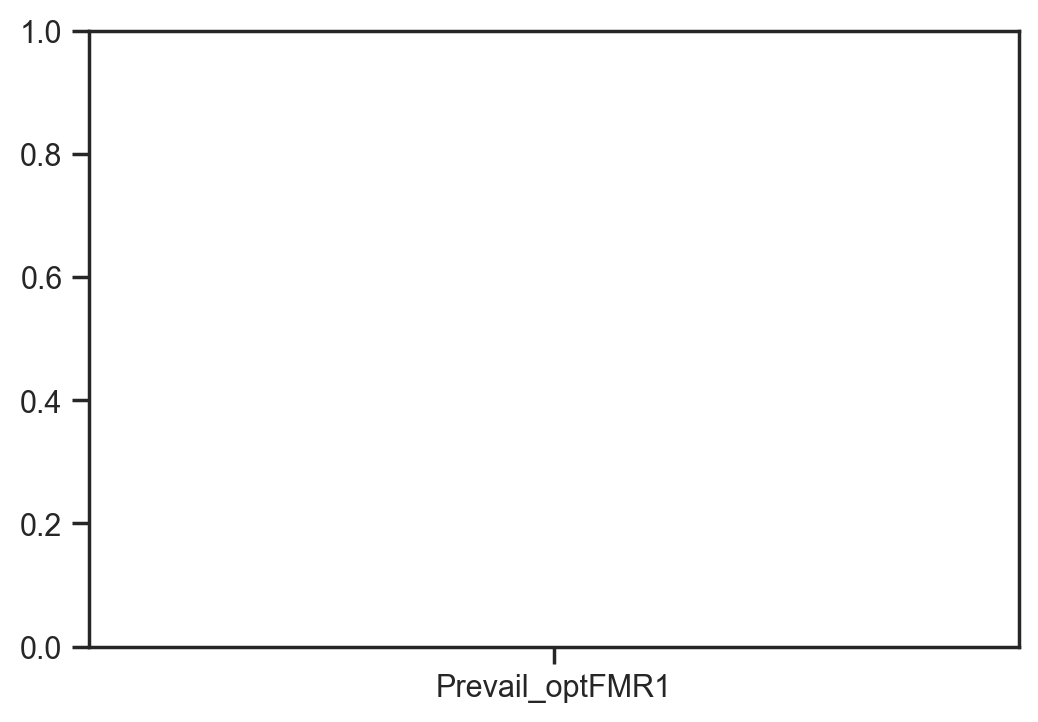

In [65]:
metric = 'Mean'
compartment = '_Nuc'
plt.figure(figsize =(6,4), dpi=200)
data = dfStudyData_plot[~dfStudyData_plot['Cargo'].isin(['Non-treated control'])]

g = sns.boxplot(data = data, 
                x = 'Cargo', 
                y = metric + compartment, 
                hue = 'Cargo',
                palette = ['darkorange','darkorchid','darkturquoise','lightgray'],
                order=ordered,
                showfliers = False)

plt.legend(loc = [1.05,0.5], title = 'Within Group animal ID')
plt.title('Cortex\nPer Cell Expression Level\n(Cells Defined by NeuN)')
g.set_ylabel('Cellular Intensity')
sns.despine(top= True, right = True)

plt.xticks(rotation=90) 

g.set_xlabel('Construct')

#plt.savefig(parent + 'NeuN/Figures/Cortex_AllSections_NeuN_' + 'PerCellIntensityBoxPlot' + metric + compartment + '.png' ,bbox_inches = 'tight')

In [204]:
percentcells.to_csv(savedir + '/COHO-0626M_PercentCells_HAcomparment_500threshold.csv')

In [187]:
savedir

'//pwcapdfs02.capsida.local/shares$/Histology/COHO-0626M'

FMR1
Capsida_optFMR1
Prevail_optFMR1
Capsida_wtFMR1
Prevail_wtFMR1
Non-treated control
GRN
Capsida_wtGRN
Prevail_wtGRN
Capsida_optGRN
Prevail_optGRN
Non-treated control


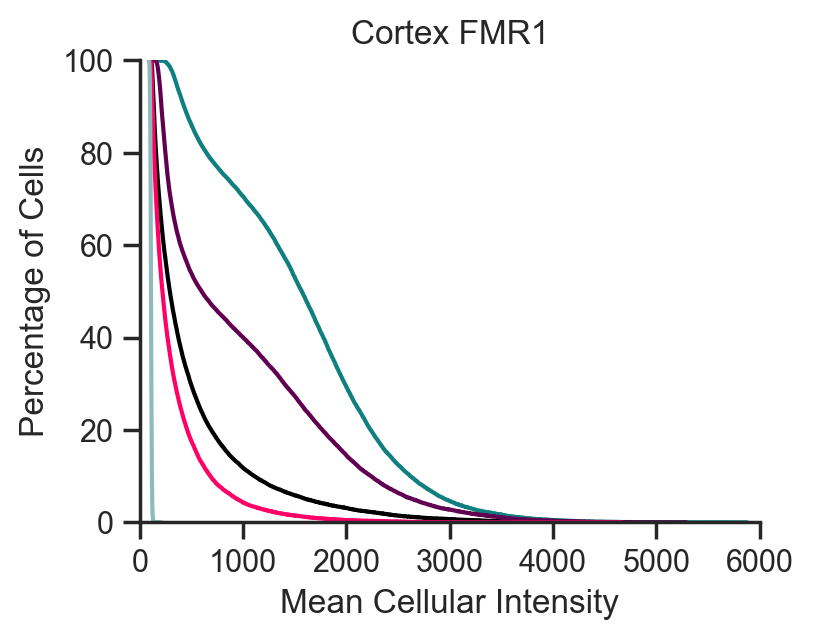

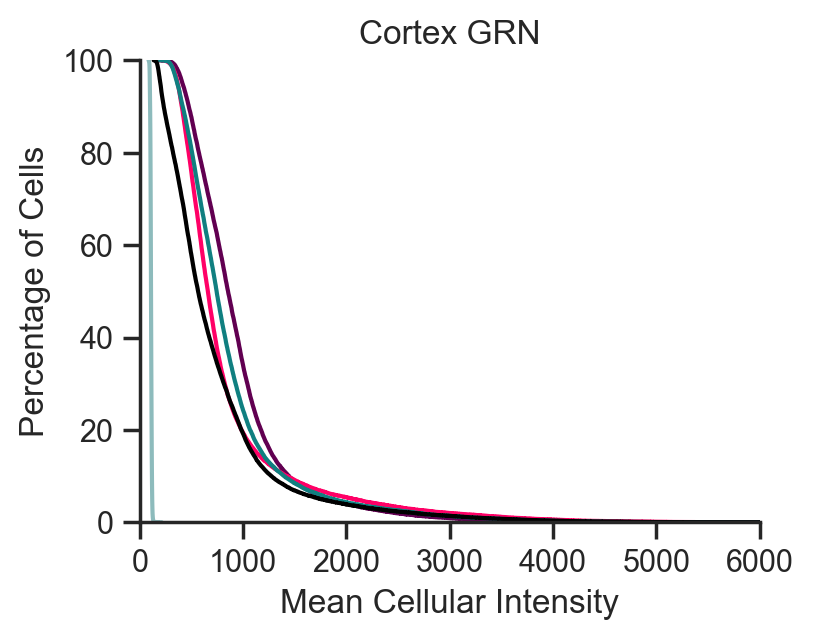

In [89]:
goilist = ['FMR1','GRN']

for item in goilist:
    print(item)
    data = dfStudyData_plot[dfStudyData_plot['Cargo'].str.contains(item)| (dfStudyData_plot['Cargo'] == 'Non-treated control')]
    
    plt.figure(figsize = (4,3), dpi = 200)
    
    for construct in data['Cargo'].unique():
        print(construct)
        data2 = data[data['Cargo'] == construct]
        cm = cdict[construct]
        g = sns.ecdfplot(data = data2, x = 'Mean_HA', legend = False, color = cm, alpha = 1, complementary = True)
        g.set_title('Cortex '+ item)
        g.set_ylabel('Percentage of Cells')
        g.set_yticklabels(range(0,120,20))
        sns.despine(top= True, right = True)
        g.set_xlabel('Mean Cellular Intensity')
        g.set_xlim(0,6000)
    plt.savefig(parent + 'NeuN/Figures/ECDFplot_construct'+item+ '_NTC.png' ,bbox_inches = 'tight')

(0.0, 105.0)

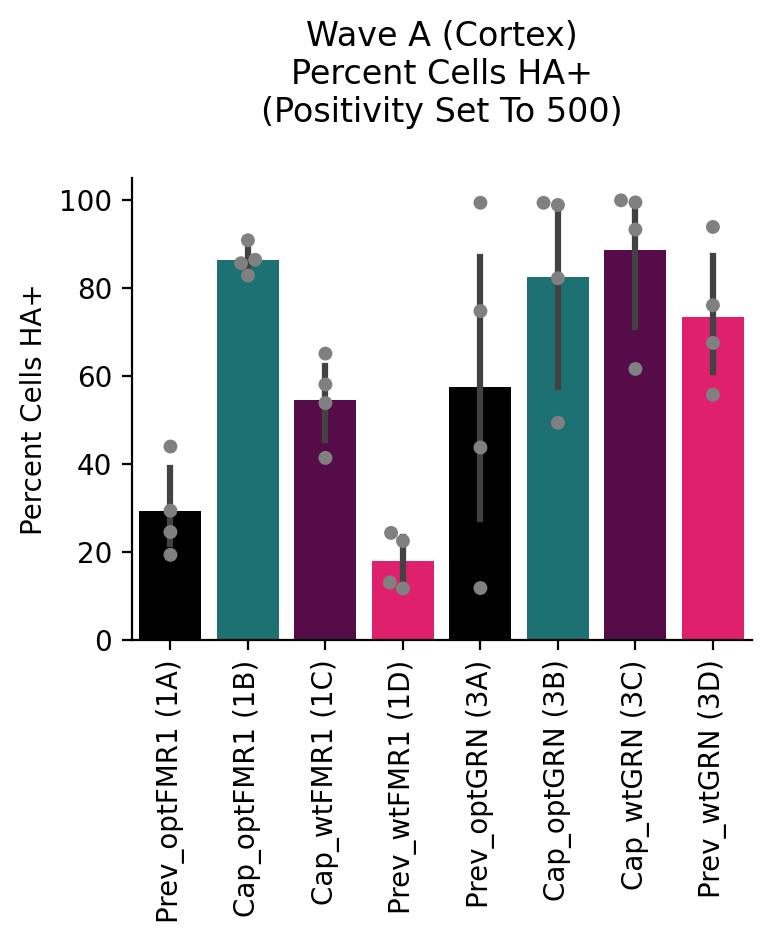

In [14]:
plt.figure(figsize = (4,3), dpi = 200)
data = percentcells[percentcells['Wave'].isin(['A'])].groupby(['Cargo','Animal', 'GroupID'])['Mean_HA'].mean().reset_index()

cm = [cdict[i] for i in ordered]
ordered2 = ['Prev_optFMR1 (1A)', 'Cap_optFMR1 (1B)', 'Cap_wtFMR1 (1C)', 'Prev_wtFMR1 (1D)',
           'Prev_optGRN (3A)', 'Cap_optGRN (3B)', 'Cap_wtGRN (3C)', 'Prev_wtGRN (3D)']

data.replace(dict(zip(ordered,ordered2)), inplace = True)
g = sns.barplot(data = data, x = 'Cargo', y ='Mean_HA', order = ordered2, hue_order = ordered2, hue ='Cargo', legend = False, palette = cm)
g = sns.swarmplot(data = data, x= 'Cargo', y = 'Mean_HA', order = ordered2, hue = 'GroupID', palette = ['gray','gray','gray','gray'], legend = False)

g.set_ylabel('Percent Cells HA+')
sns.despine(top= True, right = True)
plt.title('Wave A (Cortex)\nPercent Cells HA+\n(Positivity Set To ' + str(HAthresh)+')', pad= 20)
plt.xticks(rotation=90)
g.set_xlabel('')
g.set_ylim(0,105)
#plt.savefig(parent + 'Figures/Cortex_AllSections_PercentPositiveCells_Thresh500.png', bbox_inches = 'tight')

In [ ]:
plt.figure(figsize = (4,3), dpi = 200)

g = sns.barplot(data = percentcells[percentcells['Construct'] != 'NTC'], x = 'Construct', y ='Mean_HA', hue ='Construct', legend = False, palette = 'tab10')
g = sns.swarmplot(data = percentcells[percentcells['Construct'] != 'NTC'], x= 'Construct', y = 'Mean_HA', hue = 'GroupID', palette = ['black','black','black','black'], legend = False)

g.set_ylabel('Percent HA+')
sns.despine(top= True, right = True)
plt.title('Intensity Threshold\nFor HA Postivity Set To ' + str(HAthresh), pad= 20)
plt.xticks(rotation=90)
g.set_xlabel('')


(0.0, 6000.0)

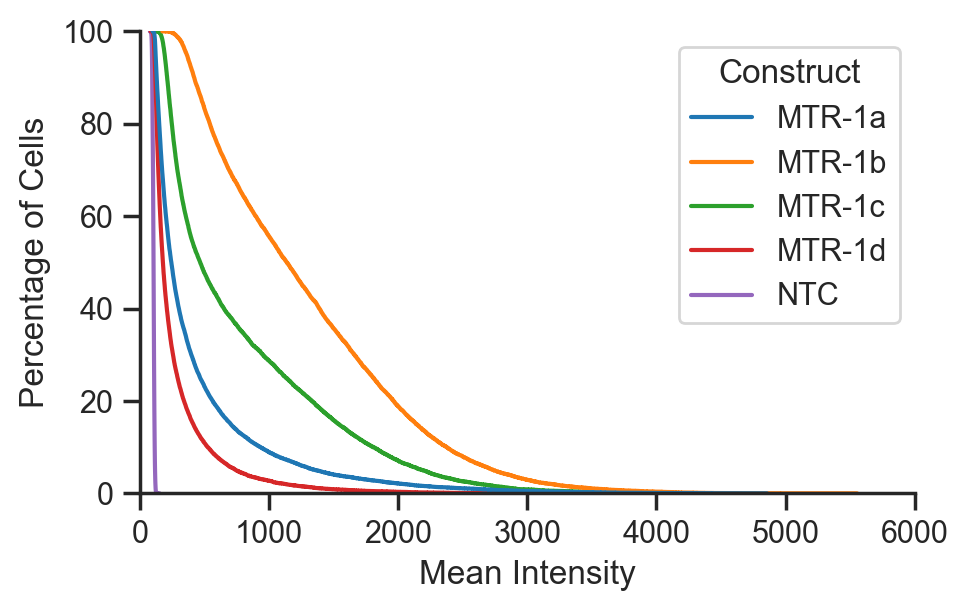

In [196]:
plt.figure(figsize = (5,3), dpi = 200)
data =  dfStudyData[dfStudyData['Construct'].str.contains('1') | dfStudyData['Construct'].str.contains('NTC')].sort_values('Construct')

g = sns.ecdfplot(data = data,x=data['Mean_HA'], hue = 'Construct', palette='tab10',complementary = True)
sns.despine(top = True)
g.set_ylabel('Percentage of Cells')
g.set_yticklabels(range(0,120,20))
g.set_xlabel('Mean Intensity')
g.set_xlim(0,6000)

Text(0.5, 0, 'Mean Intensity')

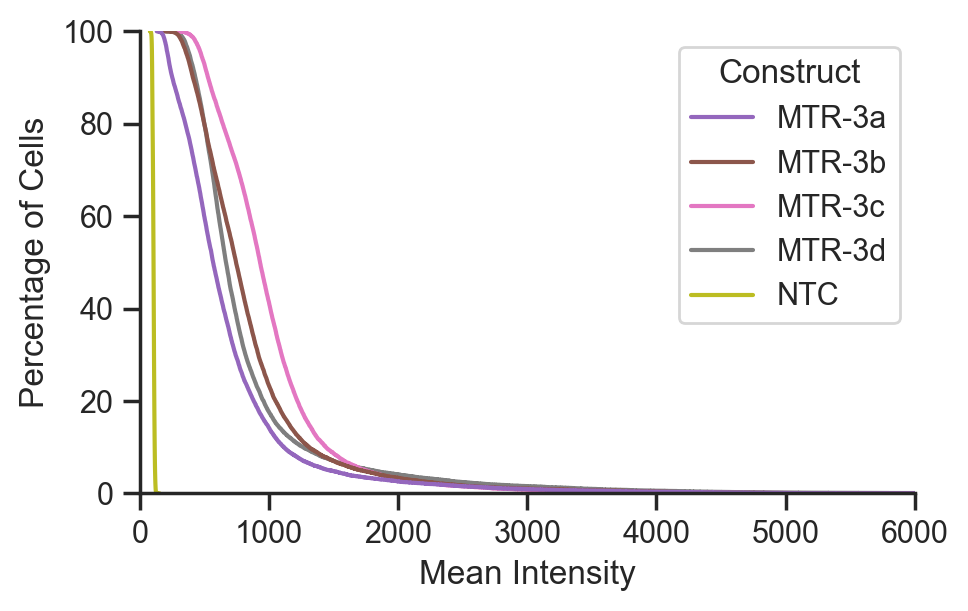

In [195]:
plt.figure(figsize = (5,3), dpi = 200)
data =  dfStudyData[dfStudyData['Construct'].str.contains('3') |dfStudyData['Construct'].str.contains('NTC')].sort_values('Construct')
colors = [cmap(i) for i in range(4, 9)]

g = sns.ecdfplot(data = data,x=data['Mean_HA'], hue = 'Construct', palette = colors, complementary=True)

sns.despine(top = True)
g.set_ylabel('Percentage of Cells')
g.set_yticklabels(range(0,120,20))
g.set_xlim(0,6000)
g.set_xlabel('Mean Intensity')

In [42]:
list1 = [i for i in os.listdir("//pwcapdfs02.capsida.local/shares$/Histology/COHO-0626M/Crops/Ctx/TIF/DAPI/") if (i.find('.tif') != -1) & (i.find('.csv') ==-1)]

list2 =  [i for i in os.listdir("//pwcapdfs02.capsida.local/shares$/Histology/COHO-0626M/Crops/Ctx/") if (i.find('.czi') != -1) & (i.find('.csv') ==-1)]
[i for i in list2 if i.replace('.czi','.tif') not in list1]

['RS7851_ctx.czi',
 'RS7855_ctx.czi',
 'WU7949_ctx.czi',
 'WU8631_ctx.czi',
 'WU8633_ctx.czi']

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, 'RS7857'),
  Text(1, 0, 'WU7947'),
  Text(2, 0, 'MK8462'),
  Text(3, 0, 'CA1133'),
  Text(4, 0, 'MK8460'),
  Text(5, 0, 'CA1131'),
  Text(6, 0, 'WU7945'),
  Text(7, 0, 'MK8456'),
  Text(8, 0, 'WU7941'),
  Text(9, 0, 'CA1247'),
  Text(10, 0, 'WU7943'),
  Text(11, 0, 'RS7853'),
  Text(12, 0, 'CA1249'),
  Text(13, 0, 'MK8458'),
  Text(14, 0, 'WU8635'),
  Text(15, 0, 'RS7865'),
  Text(16, 0, 'HE9939'),
  Text(17, 0, 'CA1141'),
  Text(18, 0, 'RS7863'),
  Text(19, 0, 'CA1139'),
  Text(20, 0, 'MK8468'),
  Text(21, 0, 'CA1135'),
  Text(22, 0, 'RS7859'),
  Text(23, 0, 'MK8464'),
  Text(24, 0, 'CA1137'),
  Text(25, 0, 'MK8466'),
  Text(26, 0, 'RS7861'),
  Text(27, 0, 'WT1'),
  Text(28, 0, 'WT3'),
  Text(29, 0, 'WT2')])

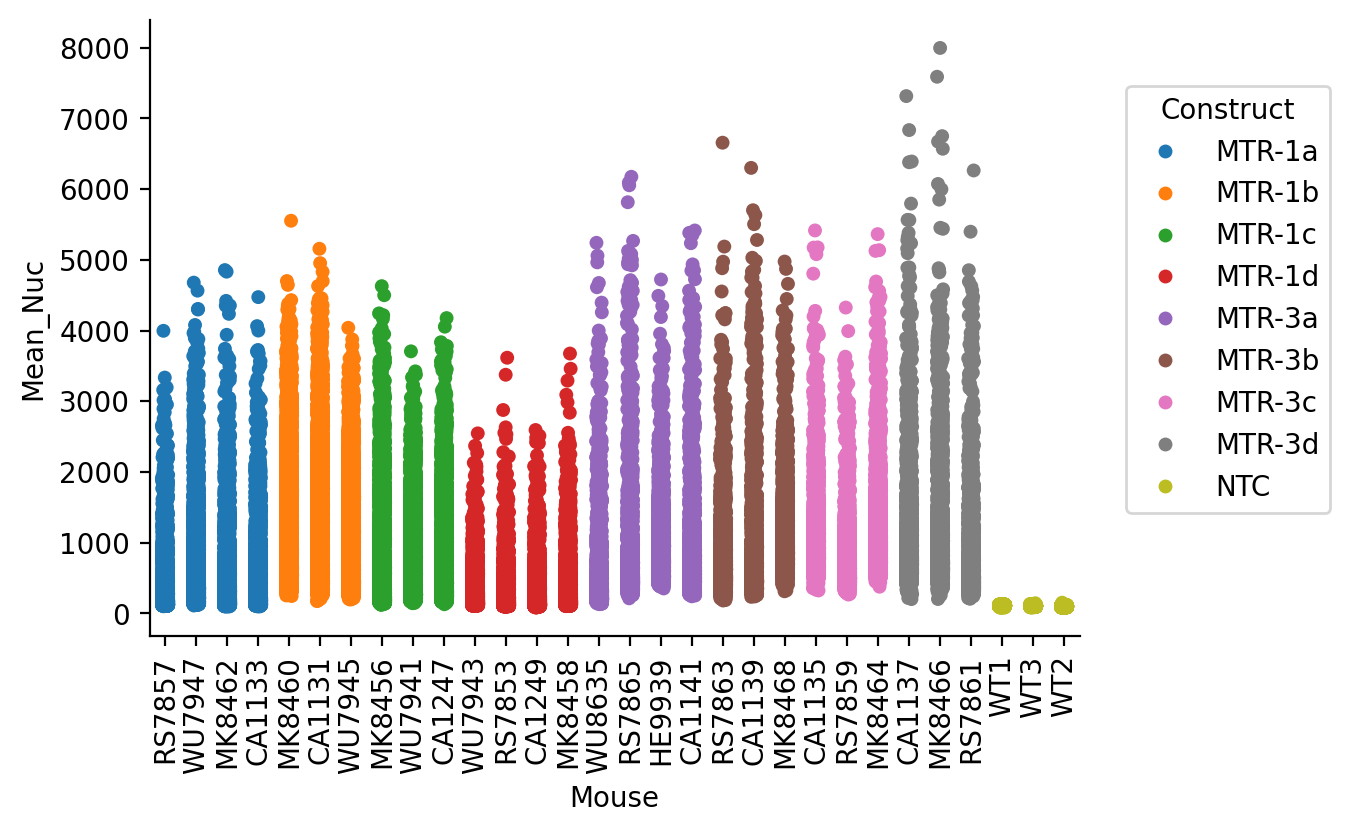

In [76]:
plt.figure(figsize = (6,4), dpi=200)
g = sns.stripplot(data = dfStudyData.sort_values('Construct'), x = 'Animal', y='Mean_Nuc', hue ='Construct')#,alpha = 0.01)
handles, labels = g.get_legend_handles_labels()
plt.legend(loc = [1.05,0.2], title = 'Construct')
sns.despine(top= True, right = True)
plt.xticks(rotation=90)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, 'RS7857'),
  Text(1, 0, 'WU7947'),
  Text(2, 0, 'MK8462'),
  Text(3, 0, 'CA1133'),
  Text(4, 0, 'MK8460'),
  Text(5, 0, 'CA1131'),
  Text(6, 0, 'WU7945'),
  Text(7, 0, 'MK8456'),
  Text(8, 0, 'WU7941'),
  Text(9, 0, 'CA1247'),
  Text(10, 0, 'WU7943'),
  Text(11, 0, 'RS7853'),
  Text(12, 0, 'CA1249'),
  Text(13, 0, 'MK8458'),
  Text(14, 0, 'WU8635'),
  Text(15, 0, 'RS7865'),
  Text(16, 0, 'HE9939'),
  Text(17, 0, 'CA1141'),
  Text(18, 0, 'RS7863'),
  Text(19, 0, 'CA1139'),
  Text(20, 0, 'MK8468'),
  Text(21, 0, 'CA1135'),
  Text(22, 0, 'RS7859'),
  Text(23, 0, 'MK8464'),
  Text(24, 0, 'CA1137'),
  Text(25, 0, 'MK8466'),
  Text(26, 0, 'RS7861'),
  Text(27, 0, 'WT1'),
  Text(28, 0, 'WT3'),
  Text(29, 0, 'WT2')])

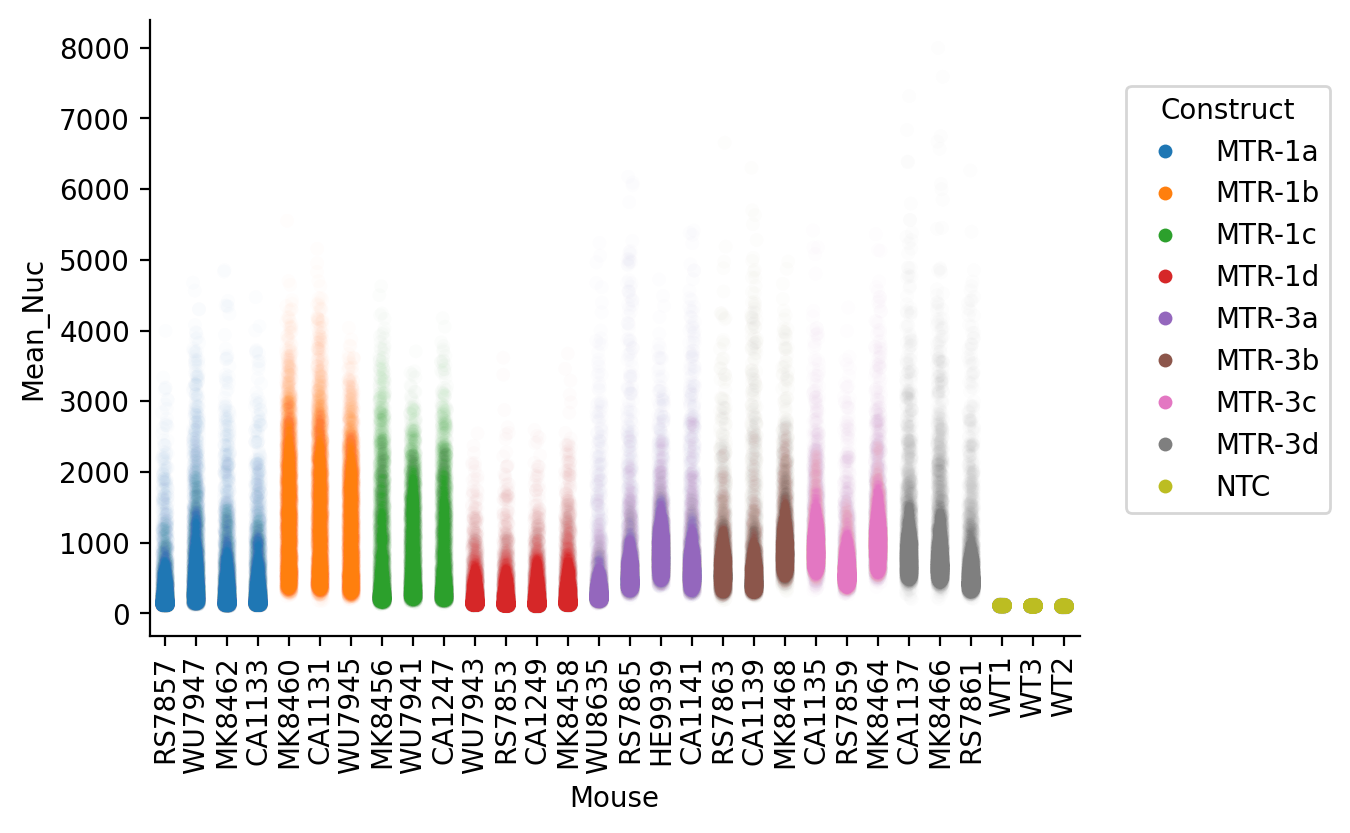

In [34]:
plt.figure(figsize = (6,4), dpi=200)
g = sns.stripplot(data = dfStudyData.sort_values('Construct'), x = 'Animal', y='Mean_Nuc', hue ='Construct',alpha = 0.01)
#handles, labels = g.get_legend_handles_labels()
plt.legend(loc = [1.05,0.2], title = 'Construct', handles = handles, labels = labels)
sns.despine(top= True, right = True)
plt.xticks(rotation=90)

In [95]:
plt.figure(figsize = (6,4), dpi=200)

g = sns.boxplot(data = dfStudyData.sort_values('Construct'), x = 'Animal', y='Mean_Nuc', hue ='Construct',showf,alpha = 0.01)
#handles, labels = g.get_legend_handles_labels()
plt.legend(loc = [1.05,0.2], title = 'Construct'), handles = handles, labels = labels)
sns.despine(top= True, right = True)
plt.xticks(rotation=90)

ValueError: Could not interpret value `construct` for `hue`. An entry with this name does not appear in `data`.

<Figure size 1200x800 with 0 Axes>

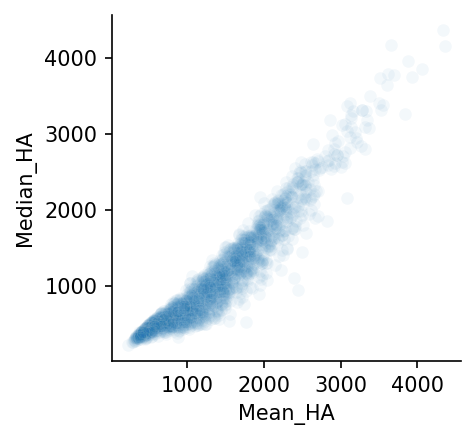

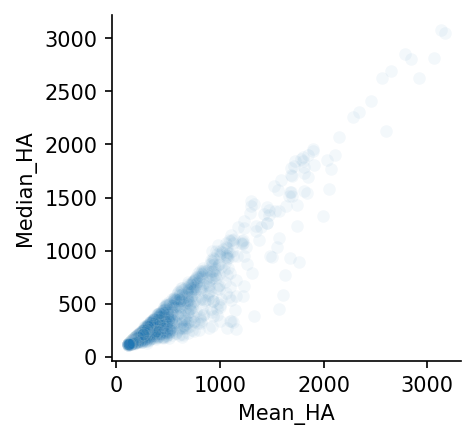

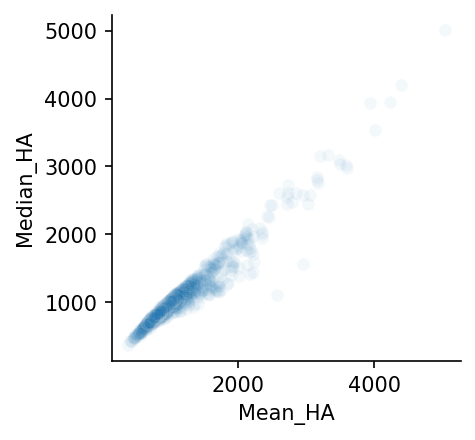

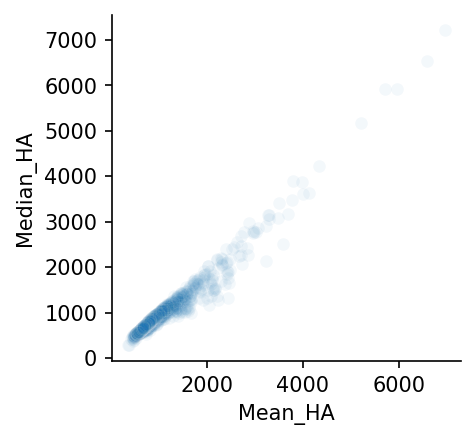

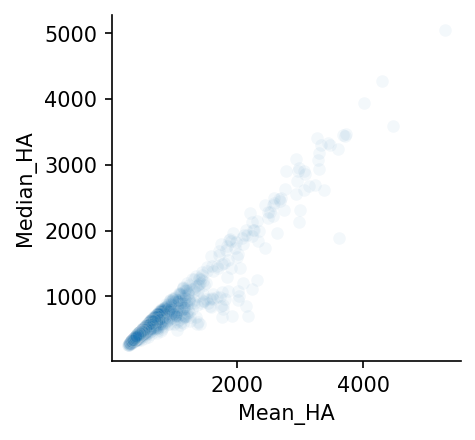

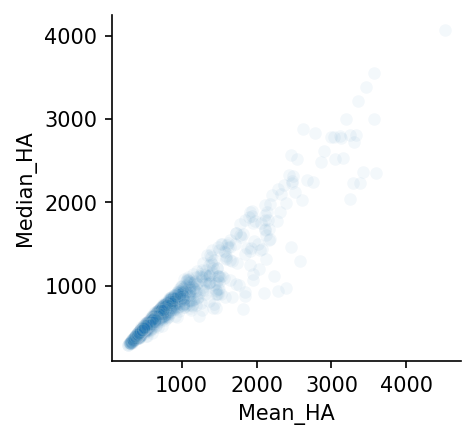

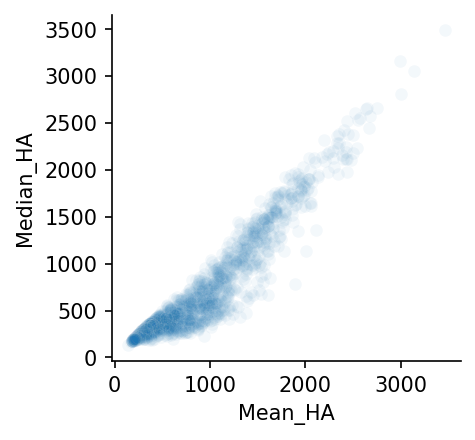

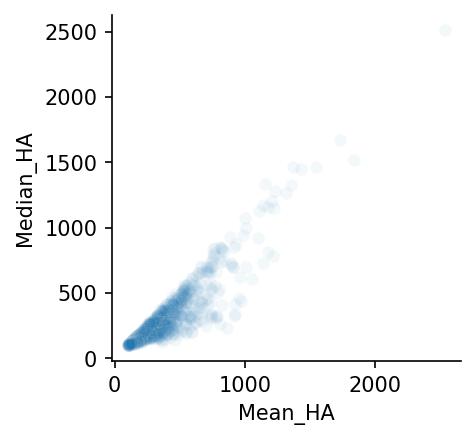

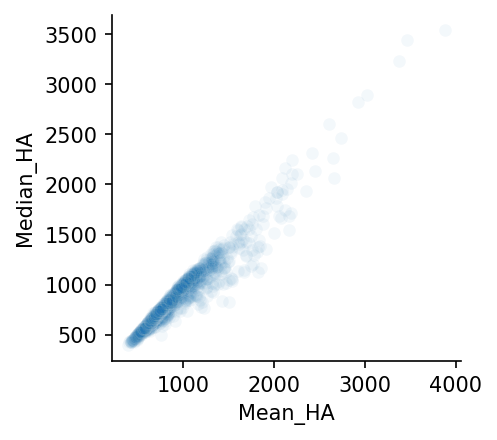

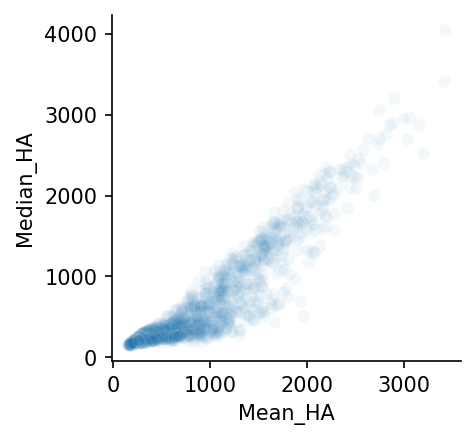

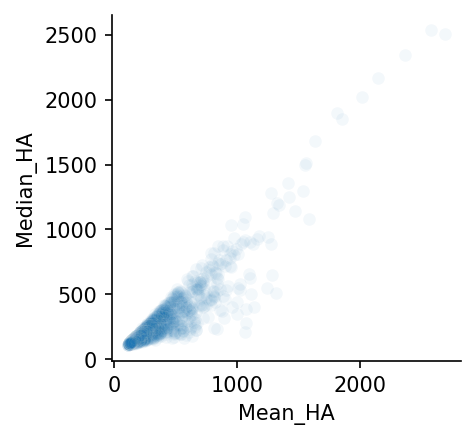

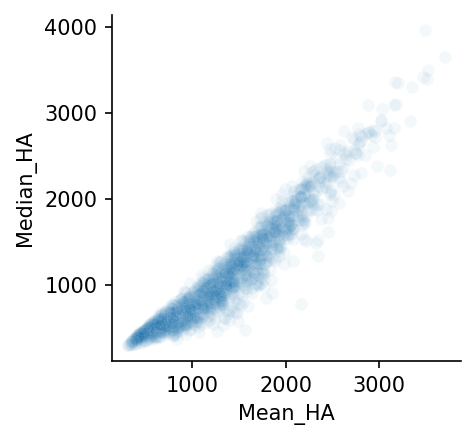

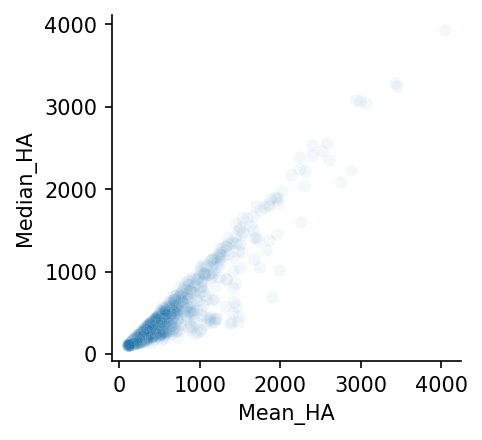

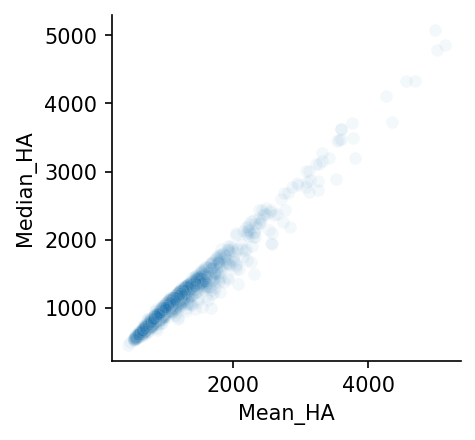

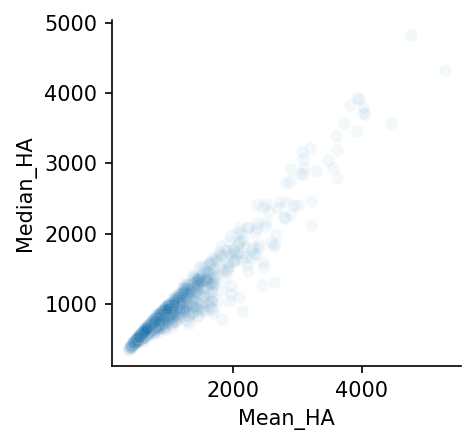

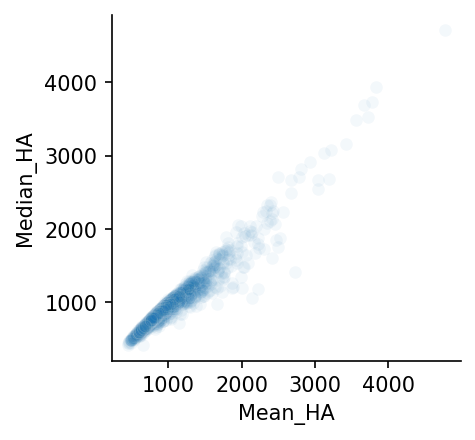

In [40]:
for animal in dfStudyData['Animal'].unique().tolist():
    plt.figure(figsize = (3,3), dpi=150)
    data = dfStudyData[dfStudyData['Animal']==animal]
    g = sns.scatterplot(data = data, x = 'Mean_HA', y='Median_HA',alpha = 0.05)
    sns.despine(top = True, right = True)

#plt.xticks(rotation=45) 

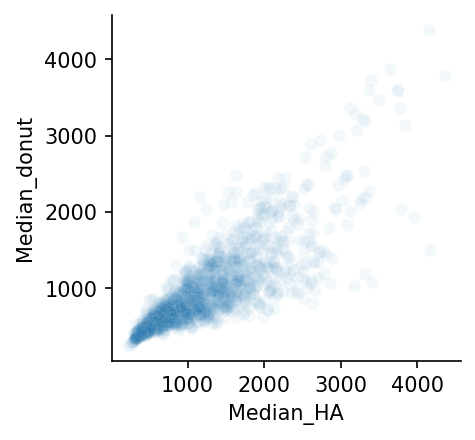

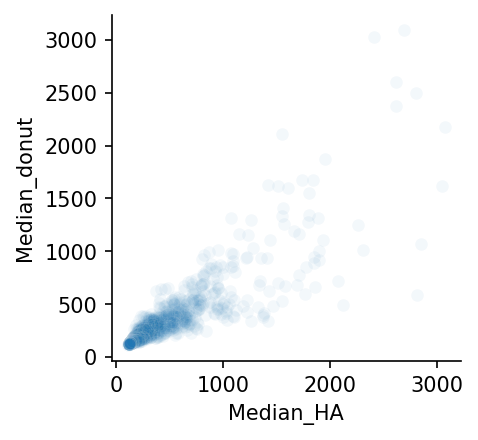

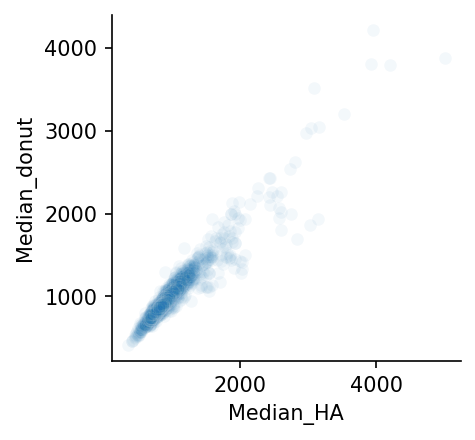

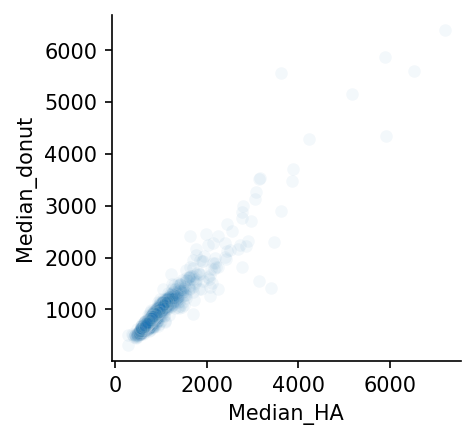

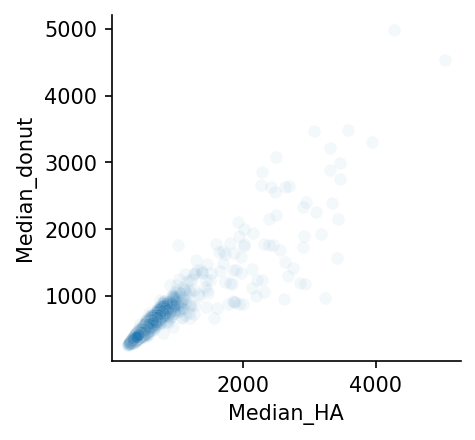

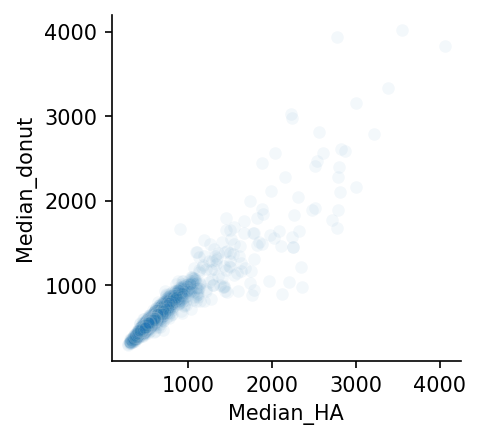

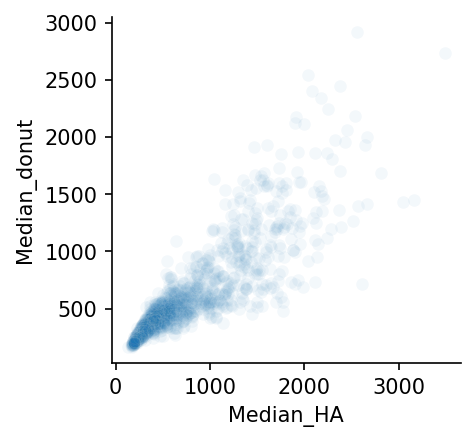

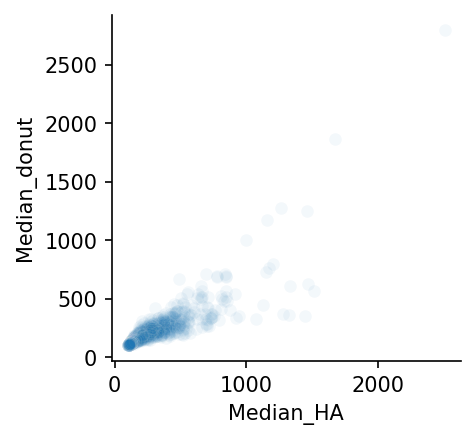

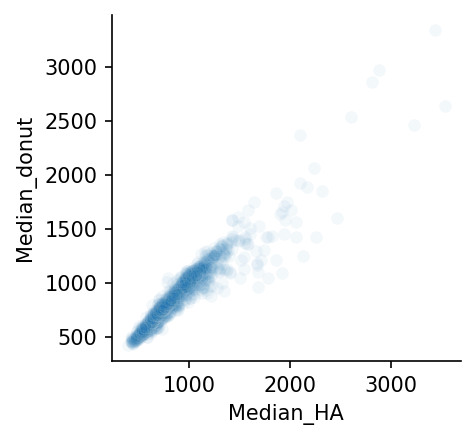

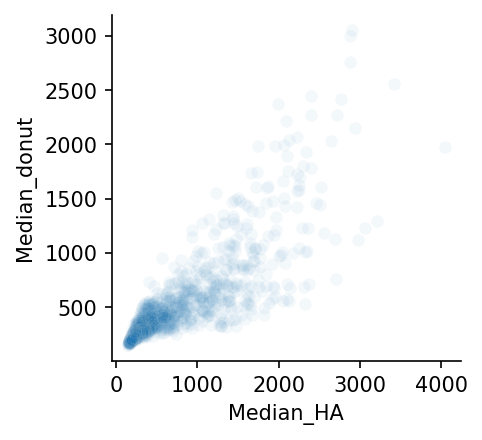

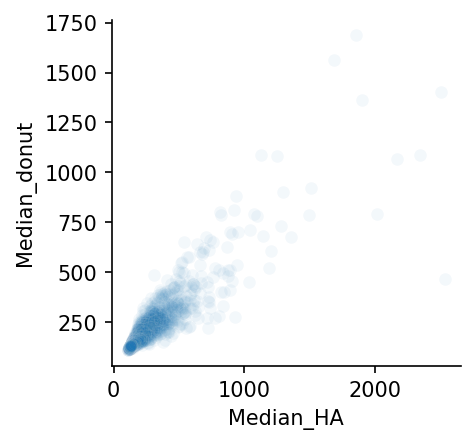

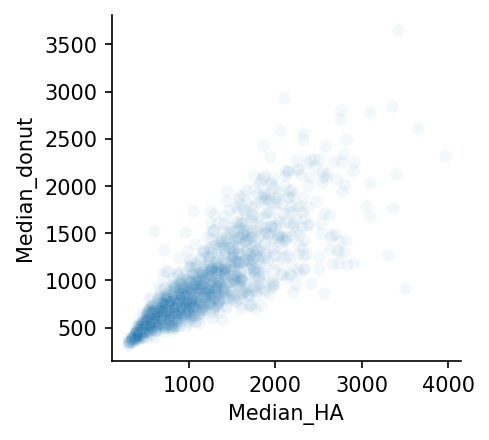

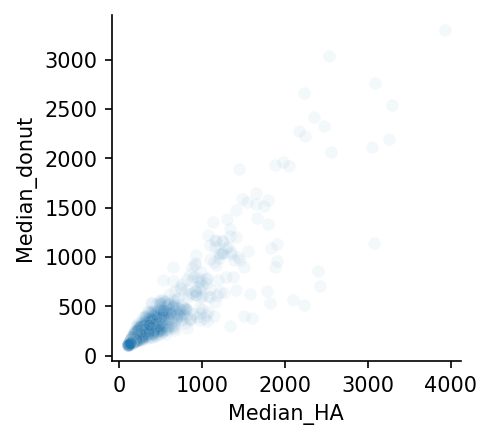

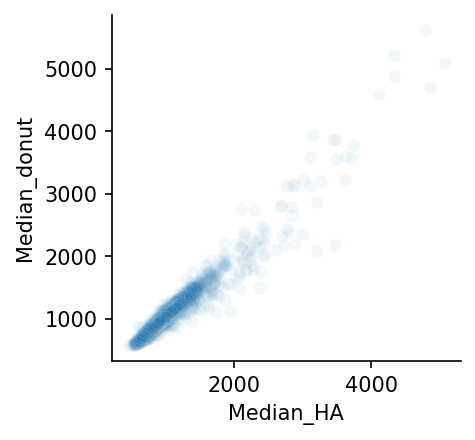

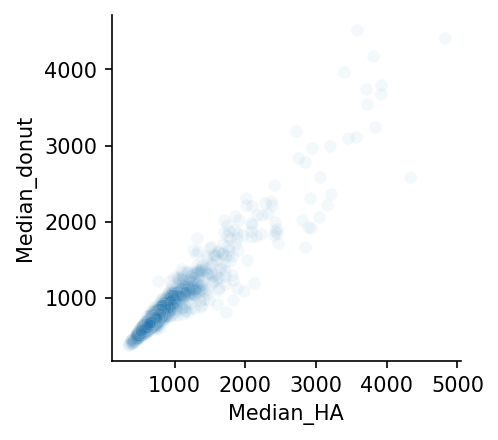

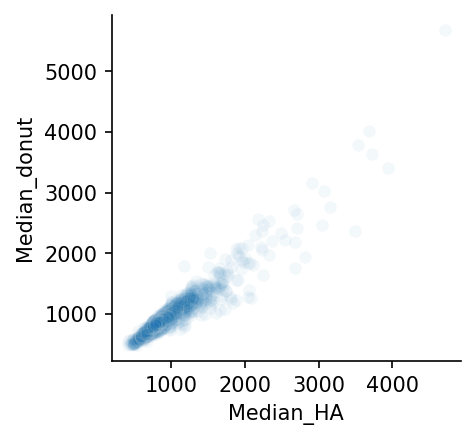

In [41]:
for animal in dfStudyData['Animal'].unique().tolist():
    plt.figure(figsize = (3,3), dpi=150)
    data = dfStudyData[dfStudyData['Animal']==animal]
    g = sns.scatterplot(data = data, x = 'Median_HA', y='Median_donut',alpha = 0.05)
    sns.despine(top = True, right = True)

#plt.xticks(rotation=45) 